Pipeline Summary

Constructs pathway-level features using PCA-based ssPA.

Runs Random Forest classifiers on:

Metabolomics-only

Transcriptomics-only

Combined multi-omics (PathIntegrate Single-View)

Evaluates models with ROC AUC, confusion matrices, and pathway importances.

Analyses pathway coverage across omics types.

Identifies top multi-omics pathway and visualises molecule-level importance via bootstrap PCA.

Generates annotated table of pathway molecules.


Importing data and libraries

In [ ]:
# Importing Libraries for data manipulation, machine learning and visualisations
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm


Loading data and metadata

In [ ]:
# Loading metadata and omics
metadata = pd.read_csv("combined_metadata_day3_4.csv").drop_duplicates('sample_id').set_index('sample_id')
metadata = metadata[metadata['Group'].isin([0, 1])]
metadata['day'] = metadata['day'].astype(int)

metab = pd.read_csv("Metabolomic_Matrix.csv", index_col=0)
transcript = pd.read_csv("Transcriptomic_Matrix.csv", index_col=0)
pathway_db = pd.read_csv("Prokaryotic_Pathway_DB_with_BGCs.csv", dtype=object).set_index('Pathway_id')
pathway_df = pd.read_csv("Prokaryotic_Pathway_DB_with_BGCs.csv", dtype=object)

# Creating pathway dictionary
pathway_dict = {
    row['Pathway_id']: row.drop(['Pathway_id', 'Pathway_name']).dropna().tolist()
    for _, row in pathway_df.iterrows()
}

# Aligning samples
shared = metab.index.intersection(transcript.index).intersection(metadata.index)
metab, transcript, metadata = metab.loc[shared], transcript.loc[shared], metadata.loc[shared]
y = pd.factorize(metadata['Group'])[0]


Creating a pathway level pca function - returns pathway scores per sample using first pc

In [ ]:
# ssPA using SVD and PCA
def sspa_svd(omics, pathways, min_entity=2, max_entity=40):
    scores, ids = [], []
    for pw_id, features in pathways.items():
        X = omics.loc[:, omics.columns.intersection(features)]
        if min_entity <= X.shape[1] <= max_entity:
            pca = PCA(n_components=1).fit(X)
            scores.append(pca.transform(X)[:, 0])
            ids.append(pw_id)
    df = pd.DataFrame(np.array(scores).T, index=omics.index, columns=ids)
    return df


# Standardising data to scale for PCA, done seperately for omics types
scaler = StandardScaler()
metab_scaled = pd.DataFrame(scaler.fit_transform(metab), index=metab.index, columns=metab.columns)
trans_scaled = pd.DataFrame(scaler.fit_transform(transcript), index=transcript.index, columns=transcript.columns)


Checking pca vs kpca

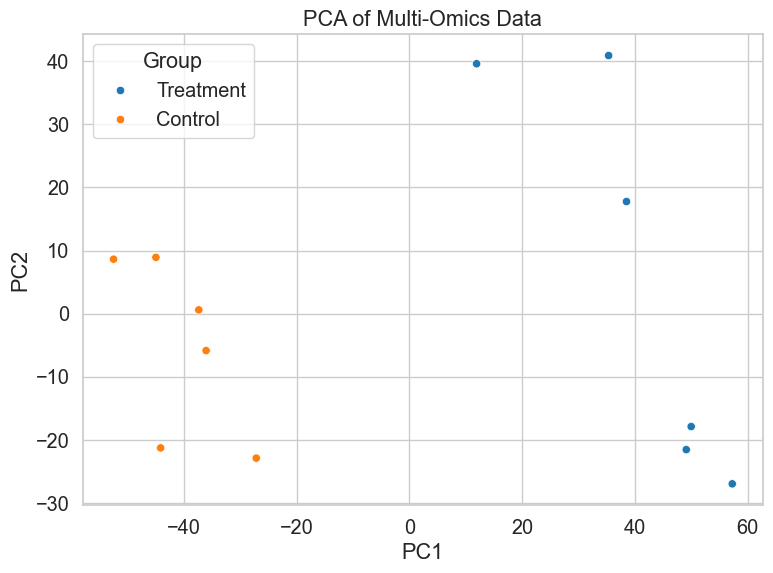

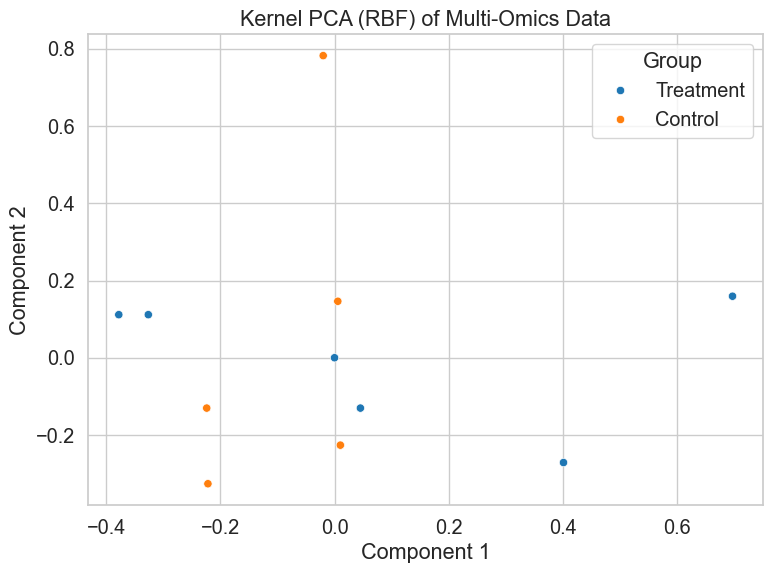

In [ ]:
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
import seaborn as sns

# Combining metabolomics and transcriptomics
combined_omics = pd.concat([metab_scaled, trans_scaled], axis=1)

# Adding group labels
group_labels = metadata['Group'].map({0: 'Control', 1: 'Treatment'})

# PCA visualisation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_omics)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=group_labels)
plt.title('PCA of Multi-Omics Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# KPCA visualisation
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1)
kpca_result = kpca.fit_transform(combined_omics)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=kpca_result[:, 0], y=kpca_result[:, 1], hue=group_labels)
plt.title('Kernel PCA (RBF) of Multi-Omics Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Group')
plt.tight_layout()
plt.show()


kpca function- not used in this notebook

In [ ]:
from sklearn.decomposition import KernelPCA

# If the KPCA was better fitted to data then this would be used
def sspa_kpca(train, test, pathways, min_entity=2, max_entity=40, kernel='rbf', gamma=None):
    scores_train, scores_test, ids = [], [], []
    for pw_id, features in pathways.items():
        X_tr = train.loc[:, train.columns.intersection(features)]
        X_te = test.loc[:, test.columns.intersection(features)]
        if min_entity <= X_tr.shape[1] <= max_entity:
            kpca = KernelPCA(n_components=1, kernel=kernel, gamma=gamma, fit_inverse_transform=False)
            X_tr_transformed = kpca.fit_transform(X_tr)
            X_te_transformed = kpca.transform(X_te)
            scores_train.append(X_tr_transformed[:, 0])
            scores_test.append(X_te_transformed[:, 0])
            ids.append(pw_id)
    df_train = pd.DataFrame(np.array(scores_train).T, index=train.index, columns=ids)
    df_test = pd.DataFrame(np.array(scores_test).T, index=test.index, columns=ids)
    return df_train, df_test


Applying pathway projection to the data

In [ ]:
# ssPA
# projects each datatype seperately 
sspa_meta = sspa_svd(metab_scaled, pathway_dict)
sspa_trans = sspa_svd(trans_scaled, pathway_dict)


# KPCA
# sspa_meta, _ = sspa_kpca(metab_scaled, metab_scaled, pathway_dict, gamma=0.1)
# sspa_trans, _ = sspa_kpca(trans_scaled, trans_scaled, pathway_dict, gamma=0.1)


# Add 'day' as a seperate covariate in the result matrix
sspa_meta['day'] = metadata['day']
sspa_trans['day'] = metadata['day']


# Multi-Omics Single-View analysis using combined omics
concat_omics = pd.concat([metab_scaled, trans_scaled], axis=1)
sspa_combined = sspa_svd(concat_omics, pathway_dict)
sspa_combined['day'] = metadata['day']


c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\decomposition\_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\decomposition\_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\decomposition\_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\sklearn\decomposition\_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [186]:
sspa_meta


,map00010,map00020,map00030,map00040,map00051,map00052,map00053,map00130,map00190,map00220,...,map04917,map04922,map04929,map04964,map04974,map04976,map04977,map04978,map07227,day
3-2_1_S18,0.934580,1.809217,-0.920915,-1.760107,0.991901,0.852457,-1.927454,-0.166289,-0.114511,-1.833664,...,0.110872,1.489199,-0.685785,-2.341184,-0.165382,-2.260054,-0.689427,0.448002,-0.629476,3
3-2_2_S19,0.695655,1.825319,-0.699151,-1.220113,0.704639,0.353552,-1.135497,-0.977925,-0.726937,-2.019706,...,0.450995,1.091834,0.196784,-1.089833,-0.524141,-1.778020,-0.079392,0.036983,0.168311,3
3-2_3_S20,-0.040247,1.375698,0.173949,-0.166417,1.294350,0.196760,0.002384,0.190676,-1.277994,-2.301322,...,0.591324,0.736586,0.521856,-1.169723,-1.839722,-0.737545,-0.201729,-1.722660,-0.831662,3
3-3_1_S21,0.292732,-1.532596,-1.243508,-0.065139,-1.601010,-0.531433,-0.698632,1.875199,1.587220,2.078189,...,-1.075155,-0.424529,-2.313607,0.494506,3.262699,-0.564418,-1.667247,2.259174,-1.687456,3
3-3_2_S22,-1.191532,-1.578588,0.765637,0.404313,-1.669762,-0.858670,-0.194195,1.441250,1.782751,2.287935,...,-1.432010,-1.331388,-0.487507,0.131720,4.461788,-2.169802,-0.036867,3.411566,-0.792478,3
3-3_3_S23,0.464036,-1.300926,-1.424006,-0.507543,-1.665775,-0.587090,-1.124569,1.415773,1.406193,1.409432,...,-1.166243,-0.231116,-0.347981,0.482542,3.518222,0.178212,-0.537599,3.576450,-1.118672,3
4-2_1_S28,0.837707,1.924175,-0.072482,-0.562006,1.749816,0.760080,0.252575,-2.844744,-1.589272,-1.991310,...,2.227445,0.864600,1.434943,0.155765,-4.109002,0.573326,1.520513,-2.614256,2.327378,4
4-2_2_S29,0.869981,1.915423,-0.095450,-0.248781,1.186260,1.326187,0.506047,-2.830775,-1.843864,-3.004476,...,2.161411,1.246417,0.207063,-0.795858,-4.351159,0.844953,1.878766,-3.460247,1.886678,4
4-2_3_S30,2.837449,1.529635,-1.780358,-1.340802,0.890335,2.856267,-0.463445,-1.913667,-1.775810,-1.576695,...,2.446888,2.742558,1.930737,-0.290978,-3.544810,-0.642818,1.395687,-3.680660,1.022570,4
4-3_1_S31,-2.350833,-2.131439,2.087616,1.957962,-0.519274,-1.804111,1.824491,1.447265,0.990555,2.579504,...,-1.550210,-2.610622,0.422206,1.599566,1.460795,2.742819,-0.282687,0.664447,-0.298856,4


In [187]:
sspa_trans

,map00020,map00030,map00040,map00051,map00052,map00053,map00061,map00130,map00140,map00195,...,BGC_r1c4,BGC_r1c6,BGC_r1c7,BGC_r1c8,BGC_r1c9,BGC_r2c1,BGC_r2c2,BGC_r2c3,BGC_r3c1,day
3-2_1_S18,-3.720113,-1.303601,1.050165,-1.509182,1.976538,1.872668,-1.989468,-0.631221,-0.363634,3.586378,...,-0.428523,1.387651,1.291193,-1.415233,0.430453,0.0,-2.305691,0.0,-0.876900,3
3-2_2_S19,-3.193287,-2.806850,2.459619,-2.373850,4.571920,2.809764,-3.784832,-2.431183,-2.009037,3.895307,...,0.557994,1.077543,0.601329,2.591195,2.540160,0.0,1.844700,0.0,-0.776437,3
3-2_3_S20,-4.104029,-3.478592,1.814885,-2.712936,4.379947,3.146922,-3.154815,-3.871512,2.136482,2.415809,...,1.208968,2.620833,-0.111656,3.218586,3.805844,0.0,0.954639,0.0,-2.190177,3
3-3_1_S21,6.185789,3.733068,-1.531272,2.961727,-3.665341,-2.618002,5.077153,3.120507,-0.254238,-2.088463,...,-1.490679,-2.148857,1.234766,-3.481308,-3.763518,0.0,0.208415,0.0,1.476555,3
3-3_2_S22,5.420643,3.982244,-1.704080,2.373209,-4.632264,-2.422655,5.034843,2.937869,0.582726,-1.860292,...,-0.512835,-5.075547,1.305510,-2.369580,-4.718932,0.0,-1.036571,0.0,2.010880,3
3-3_3_S23,3.667214,3.377411,-1.930188,2.809362,-3.369793,-2.557693,2.407372,1.931960,0.477734,-1.753478,...,-0.030040,-0.967089,0.822910,-3.258724,-3.157332,0.0,-0.694800,0.0,0.921796,3
4-2_1_S28,-5.720313,-5.384562,1.427629,-3.083954,3.473041,2.604688,-5.275324,-3.969619,0.016807,1.336510,...,0.701048,0.869452,-2.745633,4.432730,3.681103,0.0,1.238364,0.0,-1.386527,4
4-2_2_S29,-4.914755,-5.419985,3.154812,-4.135858,5.065429,2.870764,-4.353963,-3.108914,-0.067729,1.568491,...,1.928818,2.254965,-2.994112,3.934532,6.128263,0.0,0.020163,0.0,-2.097149,4
4-2_3_S30,-6.596057,-4.217588,1.675786,-3.926280,3.895303,2.510373,-3.977071,-3.082763,-1.608971,0.950090,...,2.425134,3.924880,-1.152354,4.705896,2.243495,0.0,-0.947712,0.0,-2.290149,4
4-3_1_S31,4.922379,4.153753,-1.939512,3.782754,-4.932441,-3.077922,5.134745,3.251910,-0.022818,-3.730964,...,-1.261434,-2.428148,-0.546385,-2.718851,-3.164215,0.0,-0.375924,0.0,1.934559,4


training a Random Forest classifier on pathway-level features, evaluates its performance, and visualises the results with cross validation and feature importance analysis.

In [ ]:
# Creates the cross validation object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Trains a Random forrest classifier with 200 estimators using 5 fold stratified CV
# Computes the mean ROC AUC, confusion matrix and feature importances, returning a sorted dataframe
# of importances with enriched terms
def run_rf_pipeline(X, y, pathway_db, title=""):
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc')
    print(f"{title} Mean ROC AUC (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    # Fit on full data due to limited sample size
    rf.fit(X, y)
    y_pred = rf.predict(X)
    ConfusionMatrixDisplay(confusion_matrix(y, y_pred)).plot()
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

    # Feature importances
    fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
    fi_df = fi_df[fi_df['Feature'] != 'day']
    fi_df['Name'] = fi_df['Feature'].map(pathway_db['Pathway_name'])
    fi_df = fi_df.sort_values(by='Importance', ascending=False)

    # Plotting feature importance barplot
    plt.figure(figsize=(12, 12))
    sns.set_context('paper', font_scale=1.5)
    sns.set_style('white')
    sns.barplot(data=fi_df.head(30), x='Importance', y='Name', palette='cmc.lapaz')
    plt.xlabel('Feature importance')
    plt.ylabel('')
    plt.title(f"Top Pathways: {title}")
    plt.tight_layout()
    plt.show()

    return fi_df


=== METABOLOMICS ===
Metabolomics Mean ROC AUC (CV): 1.000 ± 0.000


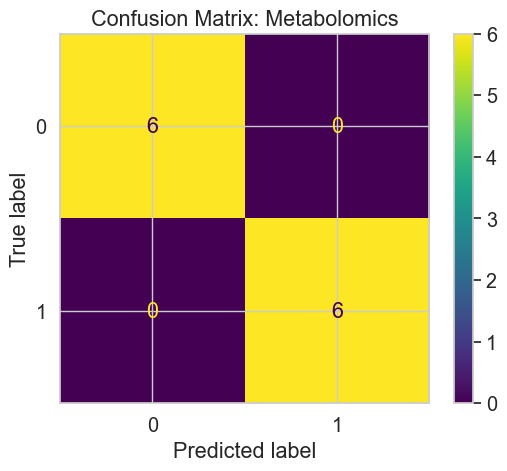

C:\Users\samri\AppData\Local\Temp\ipykernel_19440\3814846537.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df.head(30), x='Importance', y='Name', palette='cmc.lapaz')


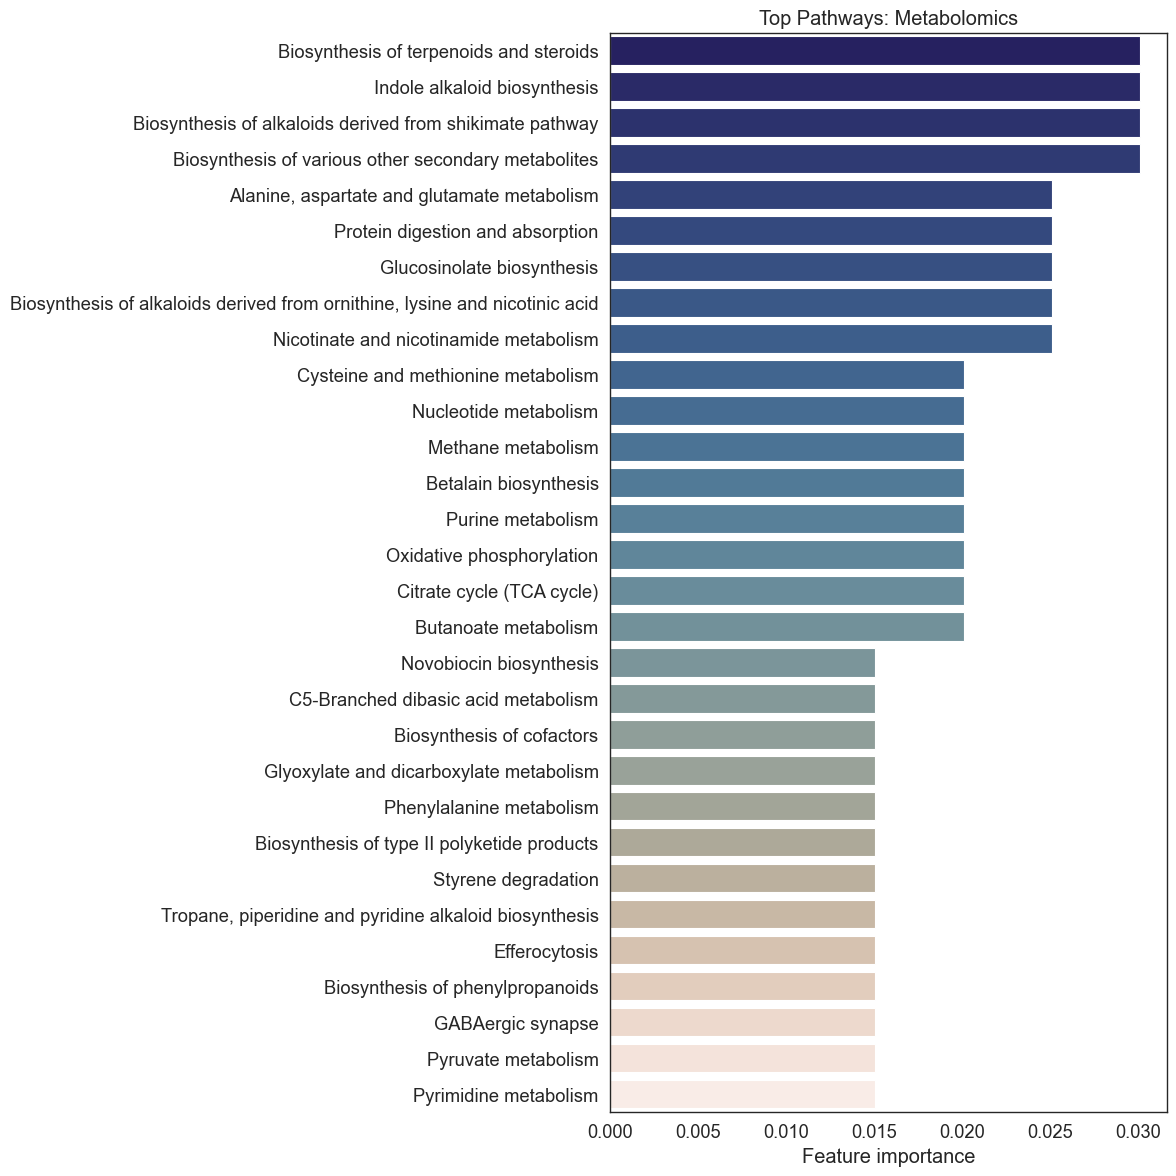

In [ ]:
# Running for Metabolomics
print("\n=== METABOLOMICS ===")
fi_meta = run_rf_pipeline(sspa_meta, y, pathway_db, title="Metabolomics")



=== TRANSCRIPTOMICS ===
Transcriptomics Mean ROC AUC (CV): 1.000 ± 0.000


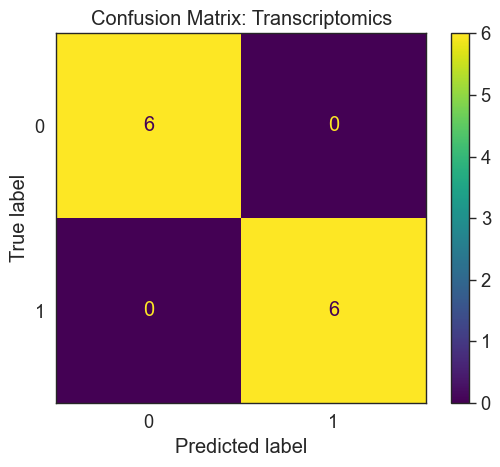

C:\Users\samri\AppData\Local\Temp\ipykernel_19440\3814846537.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df.head(30), x='Importance', y='Name', palette='cmc.lapaz')


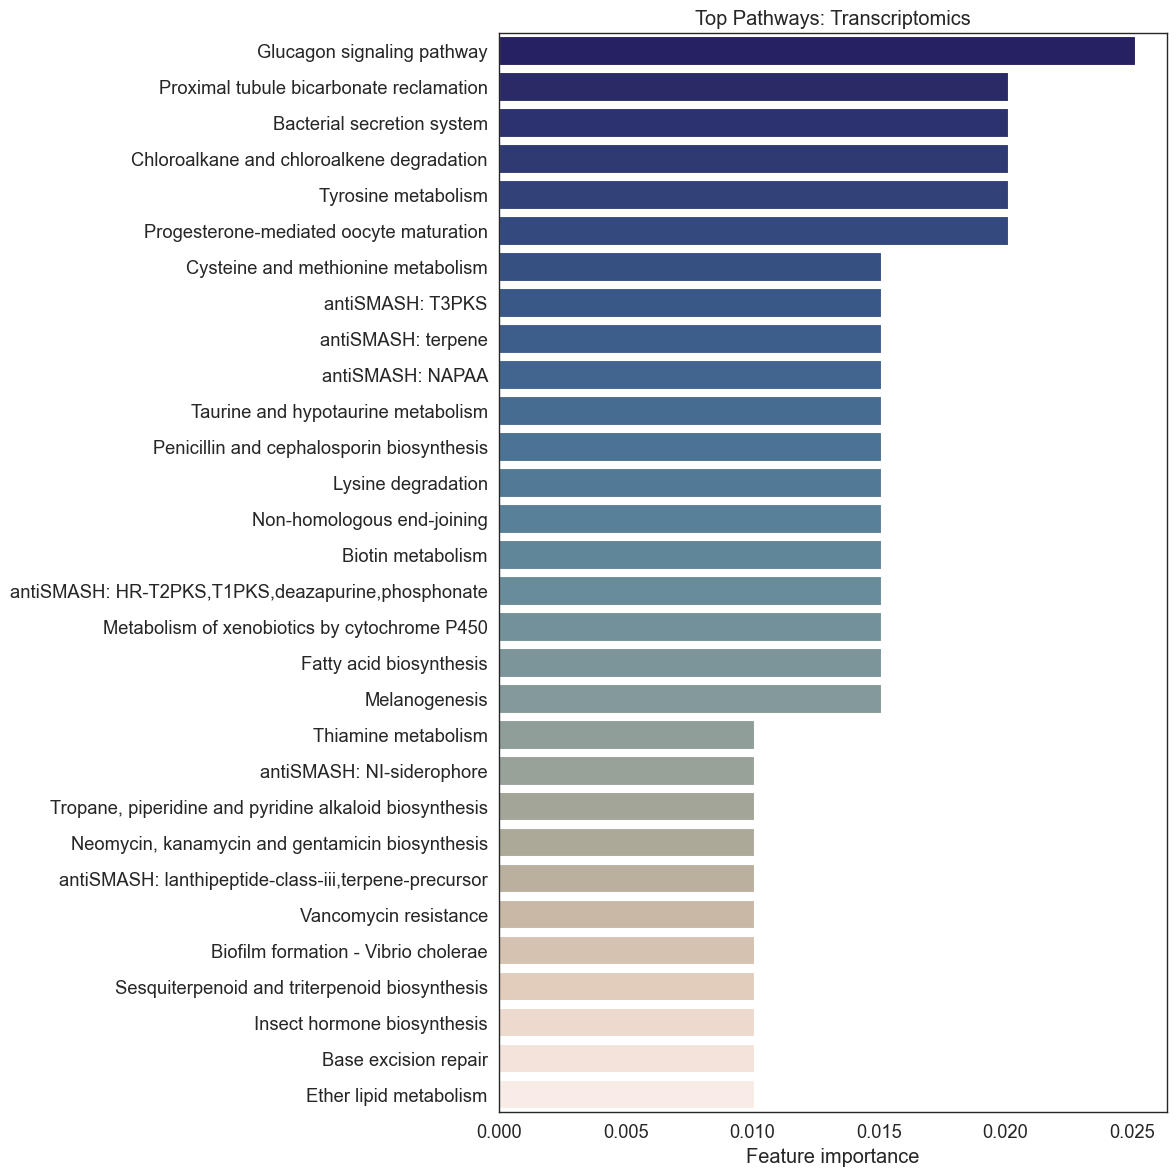

In [ ]:
# Running for Transcriptomics
print("\n=== TRANSCRIPTOMICS ===")
fi_trans = run_rf_pipeline(sspa_trans, y, pathway_db, title="Transcriptomics")


In [191]:
fi_meta['Omics'] = 'Metabolomics'
fi_trans['Omics'] = 'Transcriptomics'
fi_combined['Omics'] = 'Multi-Omics'


In [ ]:
# Formatting the top pathways into a table
def format_top_pathways_table(fi_df, pathway_dict, omics_data):
    # Get top 30
    top_df = fi_df.copy().head(30)

    # Adding feature counts per pathway
    feature_counts = []
    omics_types = []
    for pid in top_df['Feature']:
        features = pathway_dict.get(pid, [])
        count = len([f for f in features if f in omics_data.columns])
        feature_counts.append(count)
        
        # Checking which types dominate
        types = set()
        for f in features:
            if f in metab.columns:
                types.add("Metabolomics")
            elif f in transcript.columns:
                types.add("Transcriptomics")
        omics_types.append(", ".join(types))

    top_df['# Molecules'] = feature_counts
    top_df['Omics Types'] = omics_types

    # Rename for clarity
    top_df = top_df.rename(columns={
        'Feature': 'Pathway ID',
        'Name': 'Pathway Name',
        'Importance': 'Feature Importance'
    })

    return top_df[['Pathway ID', 'Pathway Name', 'Feature Importance', '# Molecules', 'Omics Types']]

# Using the  function
combined_omics = pd.concat([metab, transcript], axis=1)
top_pathways_table = format_top_pathways_table(fi_combined, pathway_dict, combined_omics)

# Displaying table
pd.set_option('display.max_rows', 100)
print(top_pathways_table.to_string(index=False))


Pathway ID                                        Pathway Name  Feature Importance  # Molecules                   Omics Types
  map03018                                     RNA degradation            0.020101           17               Transcriptomics
  map00195                                      Photosynthesis            0.020101            8               Transcriptomics
  map00030                           Pentose phosphate pathway            0.015075           35 Transcriptomics, Metabolomics
 BGC_r1c17      antiSMASH: arylpolyene,lanthipeptide-class-iii            0.015075           20               Transcriptomics
  map00670                           One carbon pool by folate            0.015075           17 Transcriptomics, Metabolomics
  map00966                          Glucosinolate biosynthesis            0.015075           11 Transcriptomics, Metabolomics
  map00040            Pentose and glucuronate interconversions            0.015075           12 Transcriptomics, Metab

In [ ]:
# Saving to CSV
top_pathways_table.to_csv("top_pathways_combined_RF_SINGLE_VIEW.csv", index=False)


In [ ]:
# Pathway Coverage Analysiss

# Identifying features present in metabolomics and transcriptomics seperately 
metab_chebi_filt = metab.copy()
proteins_ = transcript.copy()
compounds_present = [str(i) for i in metab_chebi_filt.columns.tolist()]
proteins_present = [str(i) for i in transcript.columns.tolist()]

print(f"Metabolite features (numeric): {len(compounds_present)}")
print(f"Transcriptomic features (numeric): {len(proteins_present)}")


# Pathways with more tahn 2 matched metabolites
pathways_present_metab = {k: v for k, v in pathway_dict.items() if len([i for i in compounds_present if i in v]) >= 2}
path_coverage_metab = {k: len([i for i in v if i in compounds_present]) for k, v in pathways_present_metab.items()}
print(f"Metabolomics pathways covered: {len(path_coverage_metab)}")

# Pathways with more than 2 matched transcripts
proteins_present = [str(i) for i in transcript.columns.tolist()]
pathways_present_prot = {k: v for k, v in pathway_dict.items() if len([i for i in proteins_present if i in v]) >= 2}
path_coverage_prot = {k: len([i for i in v if i in proteins_present]) for k, v in pathways_present_prot.items()}
print(f"Transcriptomics pathways covered: {len(path_coverage_prot)}")

# Multi-omics  coveragee
concat_omics_filt = pd.concat([metab_chebi_filt, transcript], axis=1)
mo_present = [str(i) for i in concat_omics_filt.columns.tolist()]
pathways_present_mo = {k: v for k, v in pathway_dict.items() if len([i for i in mo_present if i in v]) >= 2}
path_coverage_mo = {k: len([i for i in v if i in mo_present]) for k, v in pathways_present_mo.items()}
print(f"Multi-omics pathways covered: {len(path_coverage_mo)}")
print(f"Multi-omics features : {len(mo_present)}")

# Mean coveragee stats
print(f"Metabolomics: {np.mean(list(path_coverage_metab.values())):.2f}")
print(f"Transcriptomics: {np.mean(list(path_coverage_prot.values())):.2f}")
print(f"Multi-omics: {np.mean(list(path_coverage_mo.values())):.2f}")



Metabolite features (numeric): 1091
Transcriptomic features (numeric): 3224
Metabolomics pathways covered: 148
Transcriptomics pathways covered: 227
Multi-omics pathways covered: 287
Multi-omics features : 4315
Metabolomics: 7.61
Transcriptomics: 23.81
Multi-omics: 22.95


Visualising pathway size and coverage with left showing distribution and right showing coverage

C:\Users\samri\AppData\Local\Temp\ipykernel_19440\3480359185.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels=['Metabolomics', 'Transcriptomics', 'Multi-omics'], rotation=45)


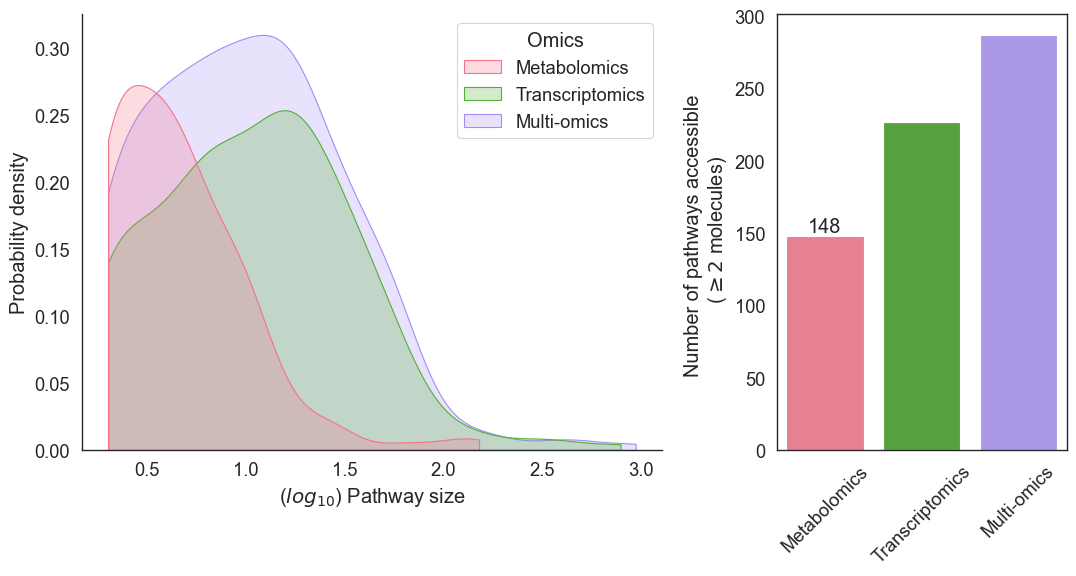

In [ ]:

# Preparing for plotting
coverage_stats = pd.concat([
    pd.DataFrame(path_coverage_metab.values(), columns=['Metabolomics']).T,
    pd.DataFrame(path_coverage_prot.values(), columns=['Transcriptomics']).T,
    pd.DataFrame(path_coverage_mo.values(), columns=['Multi-omics']).T
])
coverage_stats_melt = coverage_stats.T.melt(var_name='Omics', value_name='value')

# Plotting coverage distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), gridspec_kw={'width_ratios': [2, 1]})
sns.set_style('white')

sns.kdeplot(
    data=coverage_stats_melt,
    x=np.log10(coverage_stats_melt['value']),
    hue='Omics',
    fill=True,
    palette=[sns.color_palette('husl', 3)[0], sns.color_palette('husl', 3)[1], sns.color_palette('husl', 4)[3]],
    cut=0,
    ax=ax1
)
ax1.set_xlabel('($log_{10}$) Pathway size')
ax1.set_ylabel('Probability density')
sns.despine(ax=ax1)

sns.barplot(
    data=pd.DataFrame({
        'Metabolomics': len(path_coverage_metab),
        'Transcriptomics': len(path_coverage_prot),
        'Multi-omics': len(path_coverage_mo)
    }, index=['Pathways accessible']),
    palette=[sns.color_palette('husl', 3)[0], sns.color_palette('husl', 3)[1], sns.color_palette('husl', 4)[3]],
    ax=ax2
)
ax2.bar_label(ax2.containers[0])
ax2.set_ylabel('Number of pathways accessible \n ($\geq 2$ molecules)')
ax2.set_xticklabels(labels=['Metabolomics', 'Transcriptomics', 'Multi-omics'], rotation=45)

plt.tight_layout()
plt.show()

Function to plot molecule importances - visualises how individual molecules contribute to the top pathway identified by the classifier

In [ ]:
def plot_molecule_importances_from_pathway(imp_df, metab, transcript):
    import matplotlib.patches as mpatches

    # Preparing data
    # Converting the bootstrap PCA loading matrix into long format for plotting
    melted = imp_df.melt(var_name="Molecule", value_name="Loading")
    omics_type = ['Metabolomics' if mol in metab.columns else 'Transcriptomics' for mol in imp_df.columns]
    molecule_omics_map = dict(zip(imp_df.columns, omics_type))
    melted['Omics'] = melted['Molecule'].map(molecule_omics_map)

    # Sorting by mean for better layout
    mol_order = imp_df.mean().sort_values().index.tolist()
    melted['Molecule'] = pd.Categorical(melted['Molecule'], categories=mol_order, ordered=True)

    # Plottingg
    sns.set_context('paper', font_scale=1.8)
    sns.set_style('white')
    plt.figure(figsize=(10, max(6, 0.5 * len(imp_df.columns))))  # auto height scaling

    g = sns.pointplot(
        data=melted,
        y='Molecule',
        x='Loading',
        hue='Omics',
        dodge=False,
        errorbar='sd',
        err_kws={'linewidth': 4},
        join=False,
        palette={
            'Metabolomics': sns.color_palette('husl', 3)[0],
            'Transcriptomics': sns.color_palette('husl', 3)[1]
        }
    )

    # Mean bars are sraws point plot of loadings per molecule, colour ccoded by omics type
    for mol in imp_df.columns:
        plt.hlines(y=mol, xmin=0, xmax=imp_df[mol].mean(), color='k', linewidth=2, alpha=0.8)

    plt.axvline(0, color='k')
    plt.xlabel('Loading on PC1')
    plt.ylabel('')
    g.xaxis.grid(False)
    g.yaxis.grid(True)
    plt.legend(title='Omics Type', bbox_to_anchor=(1.0, 1.02), frameon=False)
    plt.tight_layout()
    plt.show()


molecule level imporatance function estimates molecule importance using bootstrap PCA



In [ ]:
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Bootstrap PCA to get molecule importances
# For a given pathway, runs PCA on bootstrapped data 200 times and stores the loadings
# Returns a dataframe of loadings for each molecule across bootstrap iterations
def get_molecule_importances_bootstrap(data, pathway_dict, pathway_id, nboot=200):

    # Gettingg features in the pathway
    features = pathway_dict.get(pathway_id, [])
    data_subset = data.loc[:, data.columns.intersection(features)]

# Selects relevant molecules for the top pathway and checks feature count
    if data_subset.shape[1] < 2:
        print(f"Pathway {pathway_id} has fewer than 2 features, skipping.")
        return None

# runs PCA 200 times on bootstrapped data and stores loadings for future use
    loadings = []
    for _ in range(nboot):
        sample_idx = np.random.choice(data_subset.index, size=len(data_subset), replace=True)
        sample = data_subset.loc[sample_idx]
        pca = PCA(n_components=1).fit(sample)
        loadings.append(pca.components_[0])

    return pd.DataFrame(loadings, columns=data_subset.columns)


Geting top pathway from RF, calculates molecule contributions, and visualizes.

C:\Users\samri\AppData\Local\Temp\ipykernel_19440\3752273243.py:20: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(


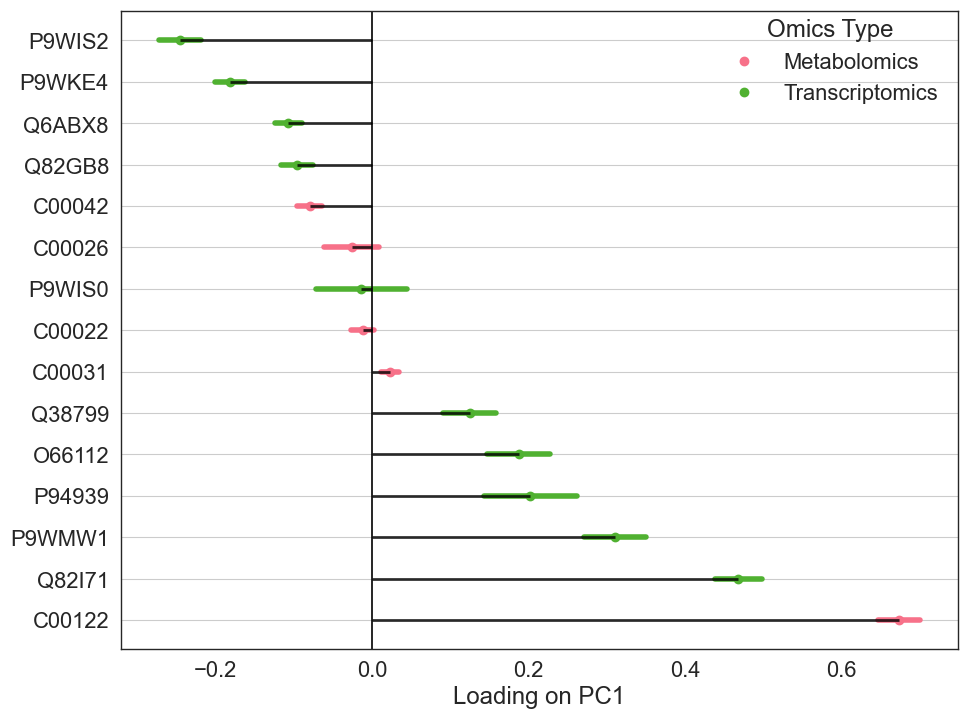

In [ ]:
# Combining omics
concat_omics_all = pd.concat([metab, transcript], axis=1).loc[metadata.index]

# Getting the top pathways from RF
top_pathway_id = fi_trans.iloc[0]['Feature']  # or fi_meta for metabolomics

# Running molecules importances
imp_df = get_molecule_importances_bootstrap(concat_omics_all, pathway_dict, top_pathway_id, nboot=200)

# Plotting features if data is available
if imp_df is not None:
    plot_molecule_importances_from_pathway(imp_df, metab, transcript)


Molecule importance table

In [ ]:
# Creating a table of molecules in the pathway with their omics type and pathway info
# Creates a dataframe with molecule ID, omics type, pathway ID and pathway name
# Returns a dataframe with molecule details
def get_molecule_table(imp_df, metab, transcript, pathway_id, pathway_db):
    # Determineing omics type
    omics_type = ['Metabolomics' if mol in metab.columns else 'Transcriptomics' for mol in imp_df.columns]
    
    # Getting pathway name if available
    pathway_name = pathway_db.loc[pathway_id, 'Pathway_name'] if pathway_id in pathway_db.index else "Unknown"

    # Building the table
    table_df = pd.DataFrame({
        'Molecule ID': imp_df.columns,
        'Omics Type': omics_type,
        'Pathway ID': pathway_id,
        'Pathway Name': pathway_name
    })

    return table_df


Running for Multi-Omics Single-View


=== MULTI-OMICS (Single-View) ===
Multi-omics (Single-View) Mean ROC AUC (CV): 1.000 ± 0.000


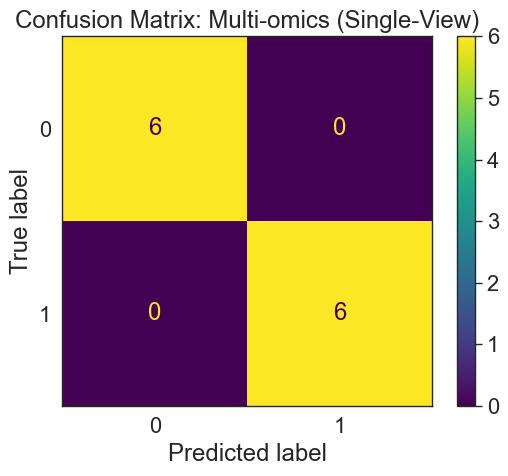

C:\Users\samri\AppData\Local\Temp\ipykernel_19440\3814846537.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df.head(30), x='Importance', y='Name', palette='cmc.lapaz')


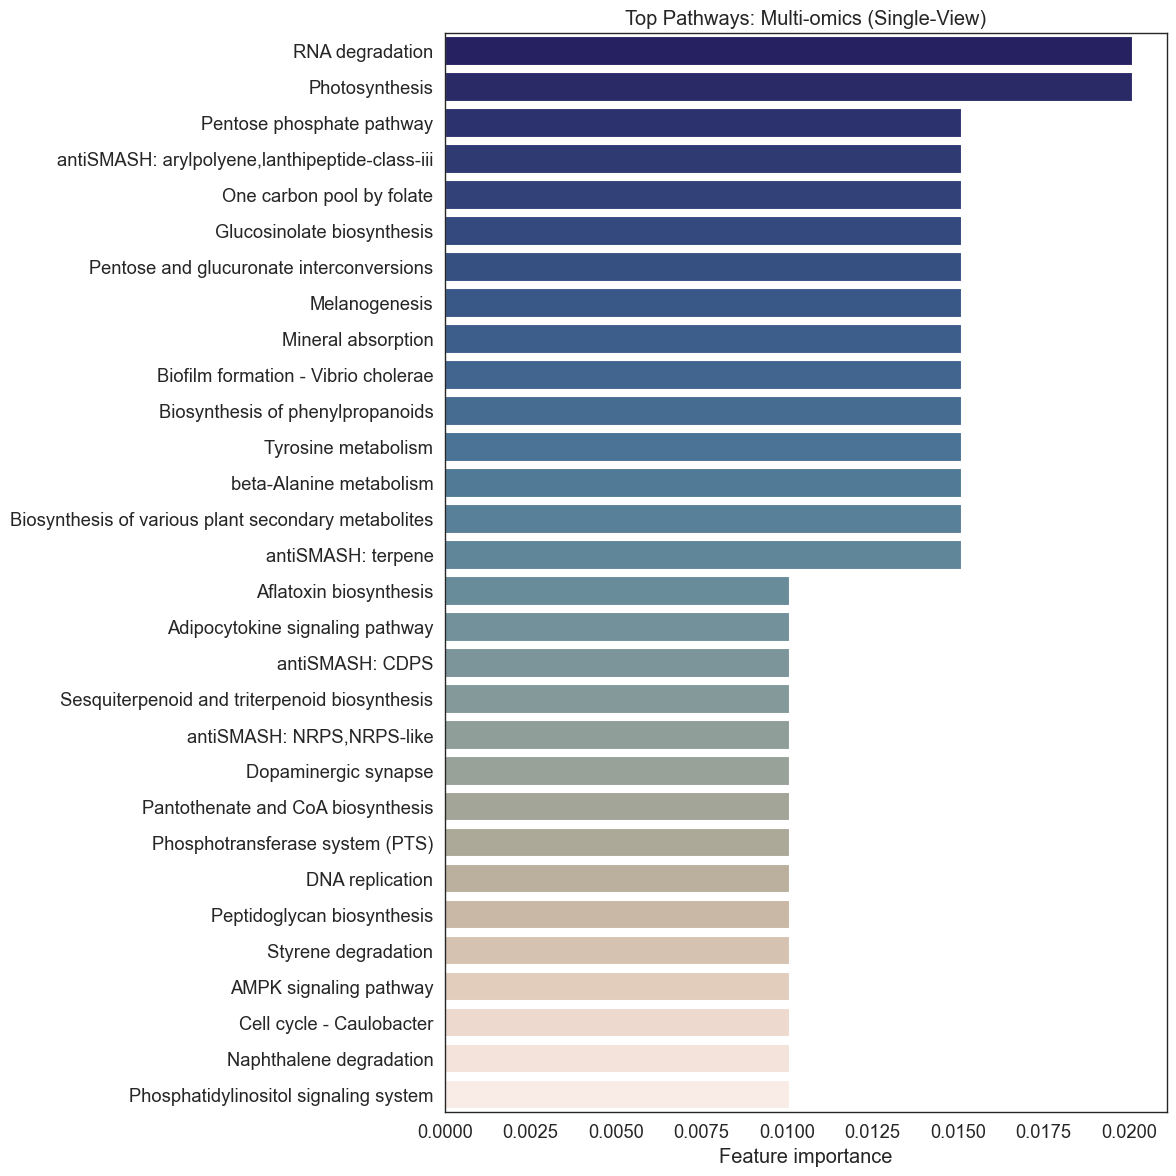

C:\Users\samri\AppData\Local\Temp\ipykernel_19440\3752273243.py:20: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(


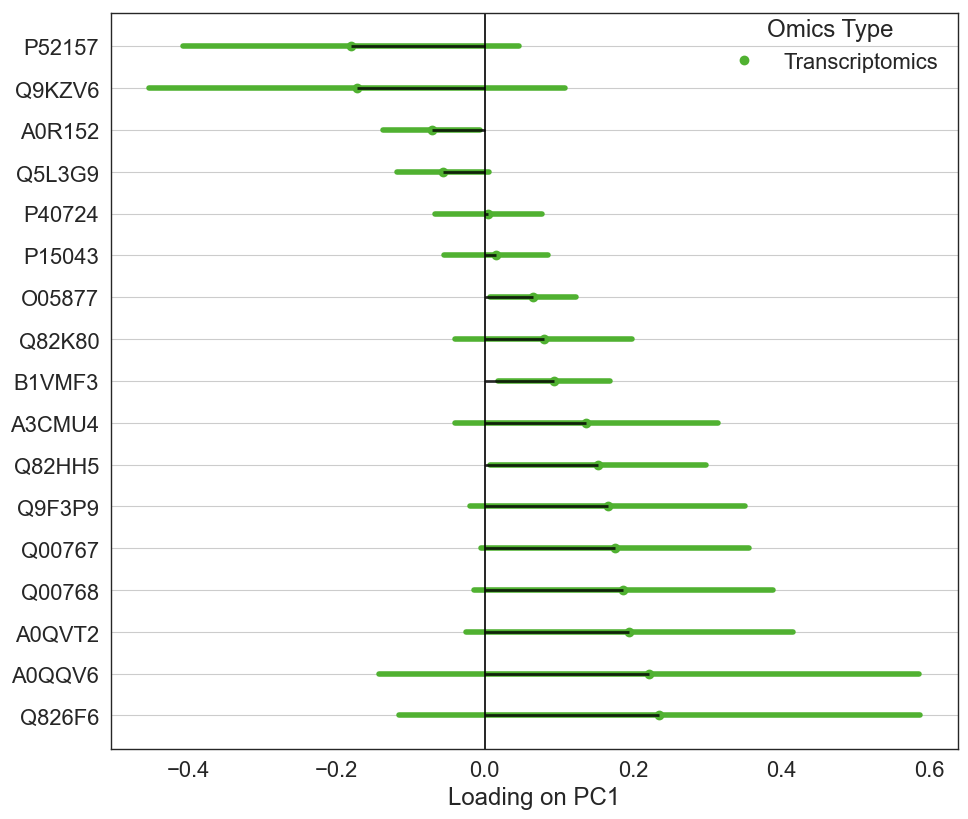

In [ ]:
# Running for Multi-Omics Single-View
# Must be ran here as we use the additional functions
print("\n=== MULTI-OMICS (Single-View) ===")
fi_combined = run_rf_pipeline(sspa_combined, y, pathway_db, title="Multi-omics (Single-View)")

# Top Pathway Molecule Importance from Multi-Omics
top_pathway_id = fi_combined.iloc[0]['Feature']
imp_df = get_molecule_importances_bootstrap(
    pd.concat([metab, transcript], axis=1), pathway_dict, top_pathway_id, nboot=200)

if imp_df is not None:
    plot_molecule_importances_from_pathway(imp_df, metab, transcript)


In [201]:

table_df = get_molecule_table(imp_df, metab, transcript, top_pathway_id, pathway_db)
display(table_df)



,Molecule ID,Omics Type,Pathway ID,Pathway Name
0,A0QQV6,Transcriptomics,map03018,RNA degradation
1,A0QVT2,Transcriptomics,map03018,RNA degradation
2,A0R152,Transcriptomics,map03018,RNA degradation
3,A3CMU4,Transcriptomics,map03018,RNA degradation
4,B1VMF3,Transcriptomics,map03018,RNA degradation
5,O05877,Transcriptomics,map03018,RNA degradation
6,P15043,Transcriptomics,map03018,RNA degradation
7,P40724,Transcriptomics,map03018,RNA degradation
8,P52157,Transcriptomics,map03018,RNA degradation
9,Q00767,Transcriptomics,map03018,RNA degradation


In [202]:
table_df

,Molecule ID,Omics Type,Pathway ID,Pathway Name
0,A0QQV6,Transcriptomics,map03018,RNA degradation
1,A0QVT2,Transcriptomics,map03018,RNA degradation
2,A0R152,Transcriptomics,map03018,RNA degradation
3,A3CMU4,Transcriptomics,map03018,RNA degradation
4,B1VMF3,Transcriptomics,map03018,RNA degradation
5,O05877,Transcriptomics,map03018,RNA degradation
6,P15043,Transcriptomics,map03018,RNA degradation
7,P40724,Transcriptomics,map03018,RNA degradation
8,P52157,Transcriptomics,map03018,RNA degradation
9,Q00767,Transcriptomics,map03018,RNA degradation


Integrating pvalues from prior univariate analysis

In [ ]:
# Loadding the external p-value file from prior analysis
pval_df = pd.read_csv("multiomics_pvalue_database.csv")
pval_df['FeatureID'] = pval_df['FeatureID'].astype(str).str.strip()
pval_df = pval_df[pval_df['Omics'].str.lower().str.contains('transcript')]  # Just Transcriptomics
pval_df = pval_df.dropna(subset=['AdjPValue'])

# Creating lookup dictionaries
pval_lookup = pval_df.set_index('FeatureID')['PValue'].to_dict()
adjp_lookup = pval_df.set_index('FeatureID')['AdjPValue'].to_dict()

# Evaluating pathway level stats from existing pathway dict
pathway_summary = []

for pid, features in pathway_dict.items():
    pathway_name = pathway_df.loc[pid, 'Pathway_name'] if pid in pathway_df.index else pid
    matched = [f for f in features if f in adjp_lookup]
    if len(matched) >= 2:
        pvals = [pval_lookup[f] for f in matched]
        adj_pvals = [adjp_lookup[f] for f in matched]
        pathway_summary.append({
            'Pathway_ID': pid,
            'Pathway_Name': pathway_name,
            'Matched Proteins': len(matched),
            '# Sig (AdjP<0.05)': sum(p < 0.05 for p in adj_pvals),
            'Min AdjP': min(adj_pvals),
            'Mean AdjP': np.mean(adj_pvals),
            'Feature_IDs': ";".join(matched)
        })

# Formatting as DataFrame
df_pathway_sig = pd.DataFrame(pathway_summary).sort_values(by='Min AdjP')
df_pathway_sig.to_csv("significant_pathways_from_pvalues.csv", index=False)

# Displaying top hits
print(df_pathway_sig.head(10))


    Pathway_ID Pathway_Name  Matched Proteins  # Sig (AdjP<0.05)  \
109   map01059     map01059                 4                  2   
80    map00760     map00760                25                  9   
110   map01100     map01100               778                380   
111   map01110     map01110               351                188   
15    map00240     map00240                55                 25   
14    map00230     map00230                86                 46   
43    map00500     map00500                34                 21   
125   map02026     map02026                 8                  5   
208  BGC_r1c30    BGC_r1c30                 7                  5   
112   map01120     map01120               307                154   

         Min AdjP  Mean AdjP  \
109  0.000000e+00   0.298646   
80   7.141524e-86   0.303379   
110  7.141524e-86   0.239290   
111  7.141524e-86   0.229172   
15   7.141524e-86   0.261774   
14   7.141524e-86   0.223971   
43   7.647181e-83   0.15132

In [ ]:
# Merging both DataFrames on pathway ID
merged = pd.merge(
    fi_combined,             # or fi_trans, or fi_meta
    df_pathway_sig, 
    left_on='Feature', 
    right_on='Pathway_ID', 
    how='inner'
)

# Normalidingg both scores (z-score or 0-1 min-max)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
merged['Importance_scaled'] = scaler.fit_transform(merged[['Importance']])
merged['NegLogP_scaled'] = scaler.fit_transform(
    (-np.log10(merged['Min AdjP'] + 1e-10)).to_frame()
)

# Combiningg into final composite score
merged['CombinedScore'] = merged['Importance_scaled'] * merged['NegLogP_scaled']

# Sorttying by combined score
top_combined = merged.sort_values(by='CombinedScore', ascending=False)

# Output or saveing
print(top_combined[['Feature', 'Name', 'Importance', 'Min AdjP', 'CombinedScore']].head(10))
top_combined.to_csv("top_combined_importance_significance.csv", index=False)


      Feature                                            Name  Importance  \
1    map00195                                  Photosynthesis    0.020101   
0    map03018                                 RNA degradation    0.020101   
4    map00670                       One carbon pool by folate    0.015075   
3   BGC_r1c17  antiSMASH: arylpolyene,lanthipeptide-class-iii    0.015075   
7    map05111             Biofilm formation - Vibrio cholerae    0.015075   
9    map00410                         beta-Alanine metabolism    0.015075   
2    map00030                       Pentose phosphate pathway    0.015075   
8    map00350                             Tyrosine metabolism    0.015075   
10  BGC_r1c32                              antiSMASH: terpene    0.015075   
5    map00040        Pentose and glucuronate interconversions    0.015075   

        Min AdjP  CombinedScore  
1   4.660121e-26       1.000000  
0   1.465183e-16       1.000000  
4   3.630334e-16       0.750000  
3   4.222842e-16

Aiming to understand directionality of pathway changes by annotating pathways as up/down regulated based on the majority direction of their significant features.

In [ ]:
# Directionality Annotation 
sspa_combined_labeled = sspa_combined.copy()
sspa_combined_labeled['Group'] = y  # 0 = ntB, 1 = ntC

# Computing group wise means for pathways
grouped_means = sspa_combined_labeled.drop(columns=['day']).groupby('Group').mean().T
grouped_means.columns = ['ntB_mean', 'ntC_mean']

# Dropping any missing data for safety
grouped_means = grouped_means.dropna(subset=['ntB_mean', 'ntC_mean'])

# Calculating log2FC and assignning direction
grouped_means['log2FC'] = np.log2((grouped_means['ntC_mean'] + 1e-6) / (grouped_means['ntB_mean'] + 1e-6))
grouped_means['Direction'] = np.where(grouped_means['log2FC'] > 0, 'Up in ntC', 'Up in ntB')

# Merging into your top combined table
top_combined_directional = top_combined.merge(
    grouped_means[['log2FC', 'Direction']],
    left_on='Feature',
    right_index=True,
    how='left'
)

# Saving a new version with directionality
top_combined_directional.to_csv("top_combined_with_directionality.csv", index=False)


c:\Users\samri\Documents\101_bioinformatics\python\Visual_studio_code\.conda\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


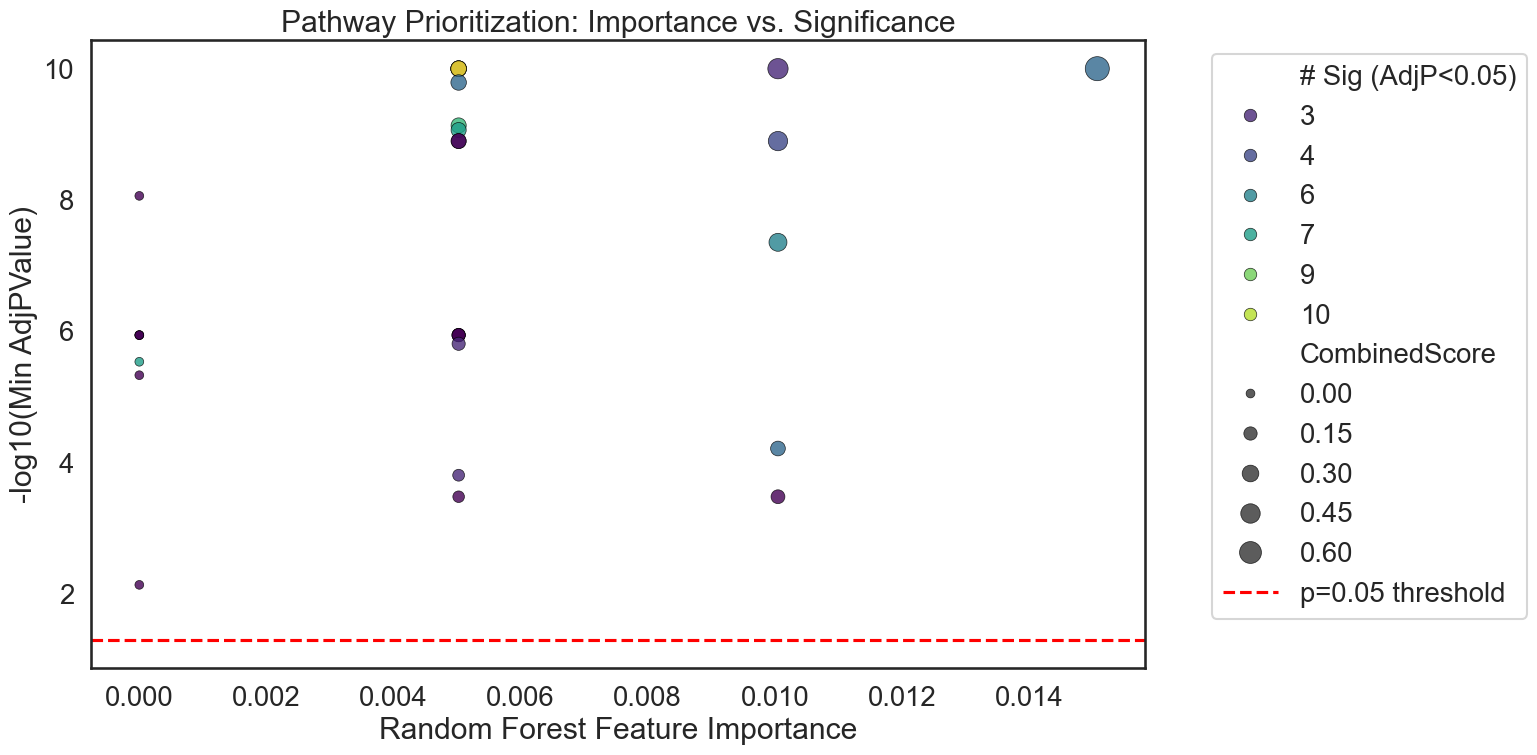

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# loading inputs
fi_df = fi_combined  # or fi_trans or fi_meta
pval_df = pd.read_csv("significant_pathways_from_pvalues.csv")  # From previous step

# Merging on pathway ID
merged = pd.merge(
    fi_df,
    pval_df,
    left_on='Feature',
    right_on='Pathway_ID',
    how='inner'
)

# Normalising scores by scaling both metrics to [0, 1] using Min-Max scaling
scaler = MinMaxScaler()
merged['Importance_scaled'] = scaler.fit_transform(merged[['Importance']])
merged['NegLogP_scaled'] = scaler.fit_transform(
    (-np.log10(merged['Min AdjP'] + 1e-10)).to_frame()
)

# Multiplies scaled importance and scaled significance to get a joint score.
merged['CombinedScore'] = merged['Importance_scaled'] * merged['NegLogP_scaled']

# Filtering to pathways with at least 2 significant entities and mean adj p-value < 0.1
filtered = merged[
    (merged['# Sig (AdjP<0.05)'] >= 2) &
    (merged['Mean AdjP'] < 0.1)
]

# Sorting by combined score descending
top_combined = filtered.sort_values(by='CombinedScore', ascending=False)

# Exportting the full and top 30 tables
top_combined.to_csv("top_combined_importance_significance.csv", index=False)
top_combined.head(30).to_csv("top_30_pathways.csv", index=False)

# Visualising the relationship between importance and significance
plt.figure(figsize=(12, 8))
sns.set_context('talk', font_scale=1.2)
sns.scatterplot(
    data=top_combined,
    x='Importance',
    y=-np.log10(top_combined['Min AdjP'] + 1e-10),
    size='CombinedScore',
    hue='# Sig (AdjP<0.05)',
    palette='viridis',
    sizes=(40, 300),
    alpha=0.8,
    edgecolor='k',
    legend='brief'
)
plt.title("Pathway Prioritization: Importance vs. Significance")
plt.xlabel("Random Forest Feature Importance")
plt.ylabel("-log10(Min AdjPValue)")
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05 threshold')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("importance_vs_significance_plot.png", dpi=300)
plt.show()


C:\Users\samri\AppData\Local\Temp\ipykernel_19440\3481234335.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\samri\AppData\Local\Temp\ipykernel_19440\3481234335.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Omics', bbox_to_anchor=(1.05, 1), loc='upper left')


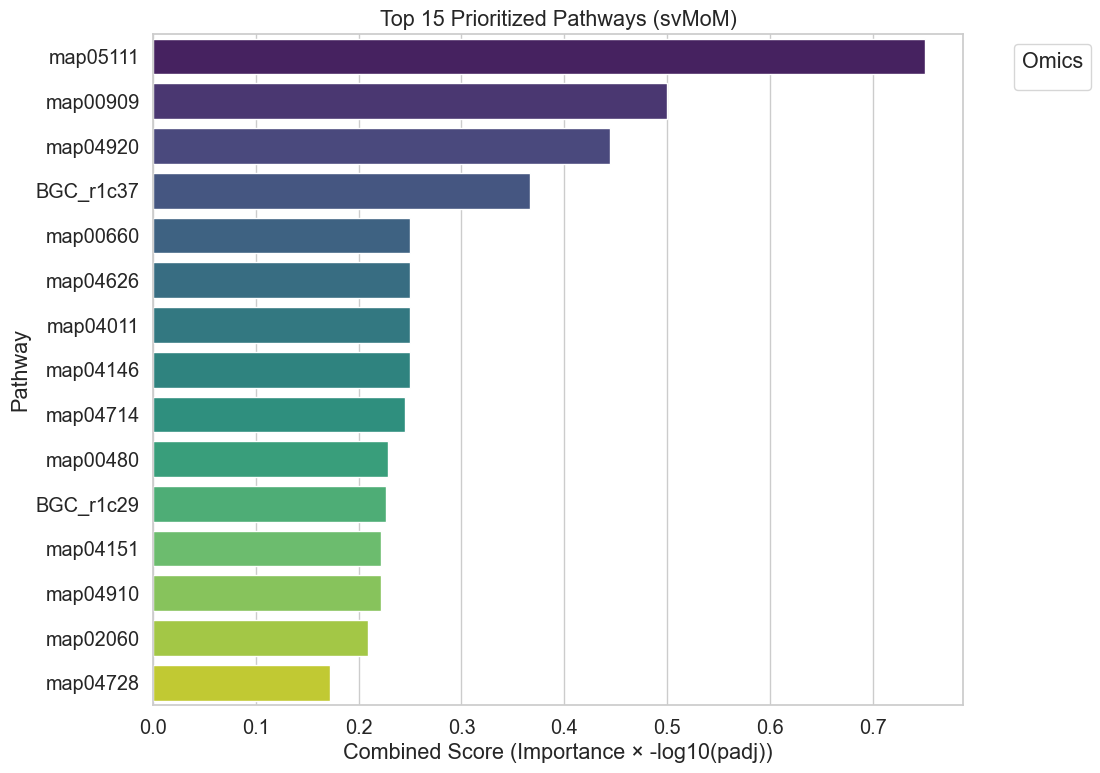

In [ ]:
# Selectting top 15 for visualization
top_N = 15
plot_df = top_combined.head(top_N).copy()

# Plottingg barplot of combined scores
plt.figure(figsize=(10, 8))
sns.set_context('notebook', font_scale=1.3)
sns.set_style('whitegrid')

sns.barplot(
    data=plot_df,
    x='CombinedScore',
    y='Pathway_Name',
    hue='Omics Types' if 'Omics Types' in plot_df.columns else None,
    palette='viridis'
)

plt.title(f"Top {top_N} Prioritized Pathways (svMoM)")
plt.xlabel("Combined Score (Importance × -log10(padj))")
plt.ylabel("Pathway")
plt.tight_layout()
plt.legend(title='Omics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("top_svMoM_pathways_barplot.png", dpi=300)
plt.show()


In [210]:
print(fi_combined.columns)
print(fi_combined.head())


Index(['Feature', 'Importance', 'Name'], dtype='object')
       Feature  Importance                                            Name
136   map03018    0.020101                                 RNA degradation
9     map00195    0.020101                                  Photosynthesis
0     map00030    0.015075                       Pentose phosphate pathway
220  BGC_r1c17    0.015075  antiSMASH: arylpolyene,lanthipeptide-class-iii
71    map00670    0.015075                       One carbon pool by folate


In [211]:
print(pval_df.columns)
print(pval_df.head())


Index(['Pathway_ID', 'Pathway_Name', 'Matched Proteins', '# Sig (AdjP<0.05)',
       'Min AdjP', 'Mean AdjP', 'Feature_IDs'],
      dtype='object')
  Pathway_ID Pathway_Name  Matched Proteins  # Sig (AdjP<0.05)      Min AdjP  \
0   map01059     map01059                 4                  2  0.000000e+00   
1   map00760     map00760                25                  9  7.141524e-86   
2   map01100     map01100               778                380  7.141524e-86   
3   map01110     map01110               351                188  7.141524e-86   
4   map00240     map00240                55                 25  7.141524e-86   

   Mean AdjP                                        Feature_IDs  
0   0.298646                        Q84HB6;Q06816;Q47690;B4ER95  
1   0.303379  Q9RJM5;Q9HWG9;H8ZPX1;Q6LQG2;Q88FY4;Q2W4A1;Q829...  
2   0.239290  Q6D8V9;O31038;Q8GGL7;O54235;O33259;P83736;B1W4...  
3   0.229172  Q6D8V9;O33259;B1W470;B7I441;B6JCP1;Q31R76;Q31J...  
4   0.261774  P0C2P0;Q6LQG2;Q2W4A1;Q8GAU3

In [ ]:
# Sampling 2 entries
import random
sample_keys = random.sample(list(pathway_dict.keys()), 2)
for k in sample_keys:
    print(f"{k}: {pathway_dict[k][:5]}")


BGC_r1c38: ['D9XF47', 'O05250', 'P0A194', 'P21627', 'P21630']
map00514: ['L8F4Z2']


In [213]:
print(pval_df.columns)

Index(['Pathway_ID', 'Pathway_Name', 'Matched Proteins', '# Sig (AdjP<0.05)',
       'Min AdjP', 'Mean AdjP', 'Feature_IDs'],
      dtype='object')


In [ ]:
print("=== fi_meta ===")
print(fi_meta.columns)

print("\n=== fi_trans ===")
print(fi_trans.columns)

print("\n=== fi_combined ===")
print(fi_combined.columns)

print("\n=== pval_df ===")
print(pval_df.columns)


=== fi_meta ===
Index(['Feature', 'Importance', 'Name', 'Omics'], dtype='object')

=== fi_trans ===
Index(['Feature', 'Importance', 'Name', 'Omics'], dtype='object')

=== fi_combined ===
Index(['Feature', 'Importance', 'Name'], dtype='object')

=== pval_df ===
Index(['Pathway_ID', 'Pathway_Name', 'Matched Proteins', '# Sig (AdjP<0.05)',
       'Min AdjP', 'Mean AdjP', 'Feature_IDs'],
      dtype='object')


In [215]:
feature_pval_df = pd.read_csv("multiomics_pvalue_database.csv")
feature_pval_df['FeatureID'] = feature_pval_df['FeatureID'].astype(str).str.strip()


In [ ]:
# Getting all molecules in top pathways from fi combined
top_pathways = set(fi_combined['Feature'])
molecules_in_top_pathways = set(
    f for pid in top_pathways if pid in pathway_dict
    for f in pathway_dict[pid]
)

# Comparing with features with p-values
features_with_pvals = set(feature_pval_df['FeatureID'].astype(str))

# Intersection with p-value features
shared_molecules = molecules_in_top_pathways.intersection(features_with_pvals)

print(f"Molecules in top RF pathways: {len(molecules_in_top_pathways)}")
print(f"Molecules in pval_df: {len(features_with_pvals)}")
print(f"Shared molecules: {len(shared_molecules)}")
print("Examples:", list(shared_molecules)[:5])


Molecules in top RF pathways: 1524
Molecules in pval_df: 4003
Shared molecules: 1473
Examples: ['Q6K4E7', 'O69768', 'A0A6N3IN21', 'O34569', 'Q827R9']


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Ensuring that FeatureIDs are clean
feature_pval_df['FeatureID'] = feature_pval_df['FeatureID'].astype(str).str.strip()
fi_combined['Feature'] = fi_combined['Feature'].astype(str).str.strip()

# Building lookup tables
pathway_importance_lookup = dict(zip(fi_combined['Feature'], fi_combined['Importance']))
pathway_name_lookup = dict(zip(fi_combined['Feature'], fi_combined['Name']))

# Building feature-to-pathway reverse map
feature_to_pathways = defaultdict(list)
for pid, mols in pathway_dict.items():
    for mol in mols:
        feature_to_pathways[mol].append(pid)

# Building annotated molecule table
rows = []
for _, row in feature_pval_df.iterrows():
    feat = row['FeatureID']
    if feat in feature_to_pathways:
        for pid in feature_to_pathways[feat]:
            if pid in pathway_importance_lookup:
                rows.append({
                    'FeatureID': feat,
                    'Omics': row['Omics'],
                    'PValue': row['PValue'],
                    'AdjPValue': row['AdjPValue'],
                    'Pathway_ID': pid,
                    'Pathway_Name': pathway_name_lookup.get(pid, pid),
                    'Pathway_Importance': pathway_importance_lookup.get(pid, 0.0)
                })

# Creating the DataFrame
df_all_feats = pd.DataFrame(rows)
df_all_feats = df_all_feats.sort_values(by=['AdjPValue', 'Pathway_Importance'])
df_all_feats.head()


,FeatureID,Omics,PValue,AdjPValue,Pathway_ID,Pathway_Name,Pathway_Importance
115,Q06816,Transcriptomics,0.000000e+00,0.000000e+00,map01059,Biosynthesis of enediyne antibiotics,0.010050
117,Q9ZN78,Transcriptomics,6.795113e-203,2.524385e-199,BGC_r1c3,antiSMASH: butyrolactone,0.005025
116,Q9ZN78,Transcriptomics,6.795113e-203,2.524385e-199,BGC_r1c11,antiSMASH: butyrolactone,0.010050
1343,Q8YAJ5,Transcriptomics,5.767045e-89,7.141524e-86,map00760,Nicotinate and nicotinamide metabolism,0.000000
118,Q6Z2T9,Transcriptomics,7.204612e-86,7.647181e-83,map00500,Starch and sucrose metabolism,0.005025


In [ ]:
df_all_feats.to_csv("Top_Significant_Features_With_Pathway_Context.csv", index=False)

# Displaying top 10 features in a markdown table
from tabulate import tabulate

top_table = df_all_feats[['FeatureID', 'Omics', 'AdjPValue', 'Pathway_Name', 'Pathway_ID', 'Pathway_Importance']].head(10)
print(tabulate(top_table, headers='keys', tablefmt='github', showindex=False))

# Saving to markdown and latex
top_table.to_markdown("top_features_table.md", index=False)
top_table.to_latex("top_features_table.tex", index=False, caption="Top-ranked molecular features and their pathways")


| FeatureID   | Omics           |    AdjPValue | Pathway_Name                           | Pathway_ID   |   Pathway_Importance |
|-------------|-----------------|--------------|----------------------------------------|--------------|----------------------|
| Q06816      | Transcriptomics | 0            | Biosynthesis of enediyne antibiotics   | map01059     |           0.0100503  |
| Q9ZN78      | Transcriptomics | 2.52438e-199 | antiSMASH: butyrolactone               | BGC_r1c3     |           0.00502513 |
| Q9ZN78      | Transcriptomics | 2.52438e-199 | antiSMASH: butyrolactone               | BGC_r1c11    |           0.0100503  |
| Q8YAJ5      | Transcriptomics | 7.14152e-86  | Nicotinate and nicotinamide metabolism | map00760     |           0          |
| Q6Z2T9      | Transcriptomics | 7.64718e-83  | Starch and sucrose metabolism          | map00500     |           0.00502513 |
| Q6Z2T9      | Transcriptomics | 7.64718e-83  | Biofilm formation - Escherichia coli   | map02026     |

In [ ]:
# Styling and saving as HTML
styled_table = top_table.style.set_caption("Top Multi-Omics Features in Informative Pathways") \
    .format({'AdjPValue': '{:.2e}', 'Pathway_Importance': '{:.4f}'}) \
    .background_gradient(subset=['AdjPValue'], cmap='Oranges_r') \
    .background_gradient(subset=['Pathway_Importance'], cmap='Blues')

styled_table.to_html("Top_Features_Filtered_Importance.html")


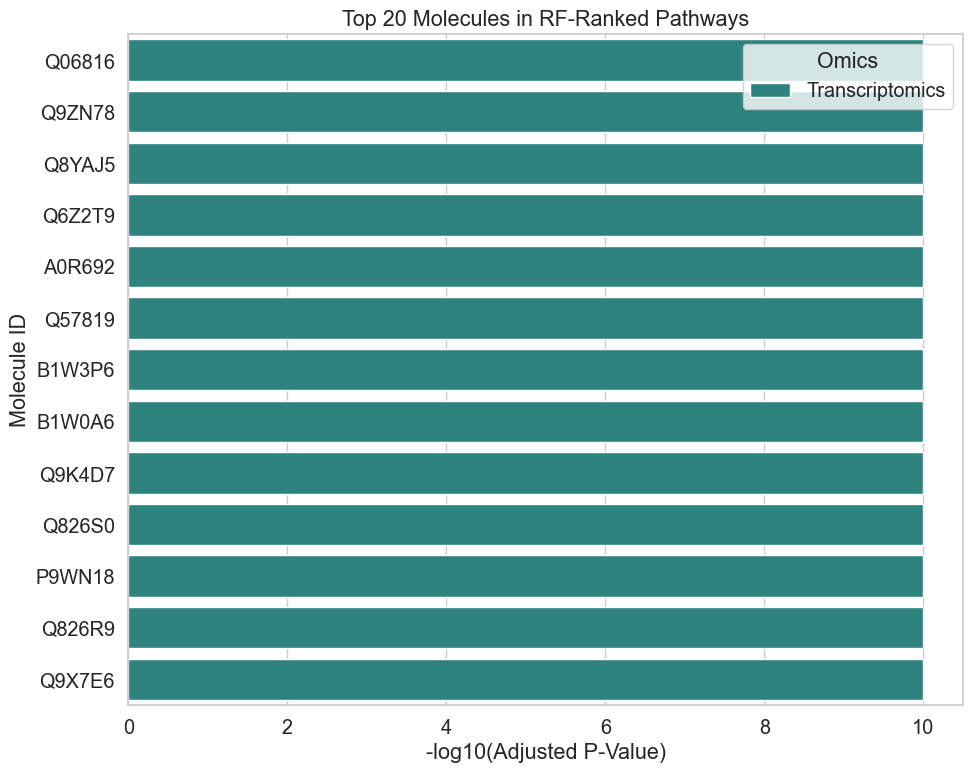

In [ ]:
# Visualising top molecules by -log10(AdjPValue) coloured by omics type
import matplotlib.pyplot as plt
import seaborn as sns

df_all_feats['-log10_AdjP'] = -np.log10(df_all_feats['AdjPValue'] + 1e-10)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_all_feats.head(20),
    y='FeatureID',
    x='-log10_AdjP',
    hue='Omics',
    dodge=False,
    palette='viridis'
)
plt.title("Top 20 Molecules in RF-Ranked Pathways")
plt.xlabel("-log10(Adjusted P-Value)")
plt.ylabel("Molecule ID")
plt.tight_layout()
plt.savefig("Top_Molecules_Plot.png", dpi=300)
plt.show()


In [ ]:
print(top_combined['Pathway_ID'].dropna().unique()[:10])
# Checking the final dataframe
print(df_all_feats.columns)
print(df_all_feats.head(3))


['map05111' 'map00909' 'map04920' 'BGC_r1c37' 'map00660' 'map04626'
 'map04011' 'map04146' 'map04714' 'map00480']
Index(['FeatureID', 'Omics', 'PValue', 'AdjPValue', 'Pathway_ID',
       'Pathway_Name', 'Pathway_Importance', '-log10_AdjP'],
      dtype='object')
    FeatureID            Omics         PValue      AdjPValue Pathway_ID  \
115    Q06816  Transcriptomics   0.000000e+00   0.000000e+00   map01059   
117    Q9ZN78  Transcriptomics  6.795113e-203  2.524385e-199   BGC_r1c3   
116    Q9ZN78  Transcriptomics  6.795113e-203  2.524385e-199  BGC_r1c11   

                             Pathway_Name  Pathway_Importance  -log10_AdjP  
115  Biosynthesis of enediyne antibiotics            0.010050         10.0  
117              antiSMASH: butyrolactone            0.005025         10.0  
116              antiSMASH: butyrolactone            0.010050         10.0  


In [ ]:
# Assigning feature importances to model-specific variable names
fi_svTM = fi_trans
fi_svMoM = fi_meta
fi_mvMoM = fi_combined

print("svTM columns:", fi_svTM.columns)
print("svMoM columns:", fi_svMoM.columns)
print("mvMoM columns:", fi_mvMoM.columns)


svTM columns: Index(['Feature', 'Importance', 'Name', 'Omics'], dtype='object')
svMoM columns: Index(['Feature', 'Importance', 'Name', 'Omics'], dtype='object')
mvMoM columns: Index(['Feature', 'Importance', 'Name'], dtype='object')


Creating tables for annotated molecules with pathway context for writup and final report
Includes feature pval, omics type, pathway name/id, and pathway importance from RF model and integrates multiview model results too

Includes manual creation and needs pathway ids

In [ ]:
# SECTION 2 — Secretion & Stress Adaptation
secretion_pathways = [
    'map03070',  # Bacterial secretion system
    'map02010',  # ABC transporters
    'map00652',  # Chloroalkane/chloroalkene degradation
    'map00350',  # Tyrosine metabolism
    'map00270',  # Cysteine and methionine metabolism
    'map00980',  # Xenobiotics metabolism by cytochrome P450
    'map02024',  # Quorum sensing
    'map00770',  # Pantothenate & CoA biosynthesis
    'map01059'   # Biosynthesis of enediyne antibiotics
]

fi_svTM = fi_trans       # Transcriptomics-only
fi_svMoM = fi_meta       # Metabolomics-only
fi_mvMoM = fi_combined   # Multi-omics single-view

# Function to extract and merge importance with p-values for given features
def extract_with_pvalues(fi_df, model_name, features):
    tmp = fi_df[fi_df['Feature'].isin(features)].copy()
    tmp['Model'] = model_name
    tmp = tmp.merge(
        pval_df[['Pathway_ID', 'Min AdjP']],
        left_on='Feature',
        right_on='Pathway_ID',
        how='left'
    )
    return tmp[['Feature', 'Name', 'Model', 'Importance', 'Min AdjP']]

# Extracting stats for secretion & stress adaptation pathways
svtm_stats = extract_with_pvalues(fi_svTM, 'svTM', secretion_pathways)
svmom_stats = extract_with_pvalues(fi_svMoM, 'svMoM', secretion_pathways)
mc_stats   = extract_with_pvalues(fi_mvMoM, 'mvMoM', secretion_pathways)

# Combining and saving the stats
combined_stats = pd.concat([svtm_stats, svmom_stats, mc_stats], ignore_index=True)
combined_stats = combined_stats.sort_values(by=['Feature', 'Model'])
print(combined_stats)
combined_stats.to_csv('section2_secretion_stress_pathways_stats.csv', index=False)


     Feature                                          Name  Model  Importance  \
6   map00270            Cysteine and methionine metabolism  svMoM    0.020101   
2   map00270            Cysteine and methionine metabolism   svTM    0.015075   
11  map00350                           Tyrosine metabolism  mvMoM    0.015075   
7   map00350                           Tyrosine metabolism  svMoM    0.010050   
1   map00350                           Tyrosine metabolism   svTM    0.020101   
12  map00770             Pantothenate and CoA biosynthesis  mvMoM    0.010050   
8   map00770             Pantothenate and CoA biosynthesis  svMoM    0.005025   
5   map00770             Pantothenate and CoA biosynthesis   svTM    0.005025   
15  map00980  Metabolism of xenobiotics by cytochrome P450  mvMoM    0.000000   
3   map00980  Metabolism of xenobiotics by cytochrome P450   svTM    0.015075   
13  map01059          Biosynthesis of enediyne antibiotics  mvMoM    0.010050   
4   map01059          Biosyn

Section 3

In [ ]:
# SECTION 3 — Central Carbon & Precursor Metabolism 
section3_paths = [
    # Aromatic/alkaloid biosynthesis & related
    'map01110', 'map01061', 'map01063', 'map01064',
    'map00360', 'map00960',
    # Redox/cofactors
    'map00760', 'map01240',
    # TCA & Glyoxylate
    'map00020', 'map00630',
    # Precursors → Polyketides
    'map00660', 'map01055',
    # PPP, RNA degradation, one-carbon, pantothenate
    'map03018', 'map00030', 'map00670', 'map00770'
]
# Extracting stats for central carbon & precursor metabolism pathways
def get_section_stats(fi_df, model_name, features):
    tmp = fi_df[fi_df['Feature'].isin(features)].copy()
    tmp['Model'] = model_name
    tmp = tmp.merge(
        pval_df[['Pathway_ID', 'Min AdjP']],
        left_on='Feature',
        right_on='Pathway_ID',
        how='left'
    )
    return tmp[['Feature', 'Name', 'Model', 'Importance', 'Min AdjP']]

svmm_stats = get_section_stats(fi_svMoM, 'svMoM', section3_paths)
svm_stats  = get_section_stats(fi_svTM,  'svTM',  section3_paths)
mv_stats   = get_section_stats(fi_mvMoM, 'mvMoM', section3_paths)

# Combining and saving the stats
section3_stats = pd.concat([svmm_stats, svm_stats, mv_stats], ignore_index=True)
section3_stats = section3_stats.sort_values(by=['Feature', 'Model'])
print(section3_stats)
section3_stats.to_csv('section3_central_carbon_stats.csv', index=False)



     Feature                                               Name  Model  \
3   map00020                          Citrate cycle (TCA cycle)  svMoM   
20  map00020                          Citrate cycle (TCA cycle)   svTM   
24  map00030                          Pentose phosphate pathway  mvMoM   
11  map00030                          Pentose phosphate pathway  svMoM   
14  map00030                          Pentose phosphate pathway   svTM   
7   map00360                           Phenylalanine metabolism  svMoM   
16  map00360                           Phenylalanine metabolism   svTM   
6   map00630            Glyoxylate and dicarboxylate metabolism  svMoM   
29  map00660                C5-Branched dibasic acid metabolism  mvMoM   
4   map00660                C5-Branched dibasic acid metabolism  svMoM   
21  map00660                C5-Branched dibasic acid metabolism   svTM   
25  map00670                          One carbon pool by folate  mvMoM   
19  map00670                          

sections 4 and 5

In [ ]:

# SECTION 4 — Secondary Metabolite Biosynthesis 
sec4_features = [
    'BGC_r1c36',  # T3PKS
    'BGC_r1c15',  # Terpene
    'BGC_r1c38',  # NAPAA
    'BGC_r1c17',  # Arylpolyene/Lanthipeptide-class-iii
    'BGC_r1c13', 'BGC_r1c19', 'BGC_r1c35',  # NI-siderophore
    'BGC_r1c37',  # CDPS
    'BGC_r1c28',  # NRPS
    'BGC_r1c24'   # T1PKS
]
 # Extracting stats for secondary metabolite biosynthesis pathways
def extract_section4(fi_df, model_name):
    tmp = fi_df[fi_df['Feature'].isin(sec4_features)].copy()
    tmp['Model'] = model_name
    result = tmp.merge(
        pval_df[['Pathway_ID', 'Min AdjP']],
        left_on='Feature',
        right_on='Pathway_ID',
        how='left'
    )
    return result[['Feature', 'Name', 'Model', 'Importance', 'Min AdjP']]

sec4_svTM  = extract_section4(fi_svTM,  'svTM')
sec4_svMoM = extract_section4(fi_svMoM, 'svMoM')
sec4_mvMoM = extract_section4(fi_mvMoM, 'mvMoM')

# Combining and saving the stats
df_section4 = pd.concat([sec4_svTM, sec4_svMoM, sec4_mvMoM], ignore_index=True)
df_section4 = df_section4.sort_values(by=['Feature', 'Model'])
print(df_section4)
df_section4.to_csv('section4_secondary_metabolism_stats.csv', index=False)


      Feature                                            Name  Model  \
15  BGC_r1c13                       antiSMASH: NI-siderophore  mvMoM   
2   BGC_r1c13                       antiSMASH: NI-siderophore   svTM   
19  BGC_r1c15                              antiSMASH: terpene  mvMoM   
7   BGC_r1c15                              antiSMASH: terpene   svTM   
10  BGC_r1c17  antiSMASH: arylpolyene,lanthipeptide-class-iii  mvMoM   
4   BGC_r1c17  antiSMASH: arylpolyene,lanthipeptide-class-iii   svTM   
14  BGC_r1c19                       antiSMASH: NI-siderophore  mvMoM   
5   BGC_r1c19                       antiSMASH: NI-siderophore   svTM   
18  BGC_r1c24                                antiSMASH: T1PKS  mvMoM   
8   BGC_r1c24                                antiSMASH: T1PKS   svTM   
13  BGC_r1c28                                 antiSMASH: NRPS  mvMoM   
3   BGC_r1c28                                 antiSMASH: NRPS   svTM   
17  BGC_r1c35                       antiSMASH: NI-siderophore  m

In [ ]:

# SECTION 5 — Volatile & Nutrient Warfare 
sec5_features = [
    'BGC_r1c21',  # Hydrogen cyanide (volatile)
    'map00020',   # TCA
    'map00630',   # Glyoxylate
    'BGC_r1c13',  # NI-siderophore (NIS)
    'map02026'    # Biofilm formation - Escherichia coli
]

# Extracting stats for volatile & nutrient warfare pathways
def extract_section5(fi_df, model_name):
    tmp = fi_df[fi_df['Feature'].isin(sec5_features)].copy()
    tmp['Model'] = model_name
    result = tmp.merge(
        pval_df[['Pathway_ID', 'Min AdjP']],
        left_on='Feature',
        right_on='Pathway_ID',
        how='left'
    )
    return result[['Feature', 'Name', 'Model', 'Importance', 'Min AdjP']]

sec5_svTM  = extract_section5(fi_svTM,  'svTM')
sec5_svMoM = extract_section5(fi_svMoM, 'svMoM')
sec5_mvMoM = extract_section5(fi_mvMoM, 'mvMoM')

# Combining and saving the stats
df_section5 = pd.concat([sec5_svTM, sec5_svMoM, sec5_mvMoM], ignore_index=True)
df_section5 = df_section5.sort_values(by=['Feature', 'Model'])
print(df_section5)
df_section5.to_csv('section5_volatile_nutrient_warfare_stats.csv', index=False)



     Feature                                     Name  Model  Importance  \
7  BGC_r1c13                antiSMASH: NI-siderophore  mvMoM    0.005025   
0  BGC_r1c13                antiSMASH: NI-siderophore   svTM    0.010050   
8  BGC_r1c21              antiSMASH: hydrogen-cyanide  mvMoM    0.000000   
2  BGC_r1c21              antiSMASH: hydrogen-cyanide   svTM    0.005025   
4   map00020                Citrate cycle (TCA cycle)  svMoM    0.020101   
3   map00020                Citrate cycle (TCA cycle)   svTM    0.000000   
5   map00630  Glyoxylate and dicarboxylate metabolism  svMoM    0.015075   
6   map02026     Biofilm formation - Escherichia coli  mvMoM    0.005025   
1   map02026     Biofilm formation - Escherichia coli   svTM    0.010050   

       Min AdjP  
7  4.415662e-07  
0  4.415662e-07  
8  2.924711e-06  
2  2.924711e-06  
4  6.590650e-28  
3  6.590650e-28  
5  7.898305e-16  
6  7.647181e-83  
1  7.647181e-83  


In [ ]:
# Add summary stats to section tables

# Ensure clean p-value table (use all omics, not just transcriptomics)
feature_pval_df = feature_pval_df.copy()
feature_pval_df['FeatureID'] = feature_pval_df['FeatureID'].astype(str).str.strip()
feature_pval_df = feature_pval_df.dropna(subset=['AdjPValue'])

# Creating lookup dictionaries
feat_adj_lookup = dict(zip(feature_pval_df['FeatureID'], feature_pval_df['AdjPValue']))
tx_cols  = set(str(c) for c in transcript.columns)
met_cols = set(str(c) for c in metab.columns)

# Function to count features per pathway
def _count_features_for_pathway(pid):
    feats = pathway_dict.get(pid, [])
    n_tx  = sum(1 for f in feats if f in tx_cols)
    n_met = sum(1 for f in feats if f in met_cols)
    return n_tx, n_met, n_tx + n_met

# Function to get adjP stats per pathway
def _adjp_stats_for_pathway(pid):
    feats = pathway_dict.get(pid, [])
    vals  = [feat_adj_lookup[f] for f in feats if f in feat_adj_lookup]
    if len(vals) == 0:
        return np.nan, np.nan, np.nan
    return np.min(vals), np.max(vals), float(np.mean(vals))

# Function to add stats to a section DataFrame
def add_section_stats(df):
    # df must have a feature column with KEGG/BGC IDs
    stats = df[['Feature']].drop_duplicates().copy()
    stats[['n_transcriptomic','n_metabolomic','n_features_total']] = stats['Feature'] \
        .apply(lambda pid: pd.Series(_count_features_for_pathway(pid)))
    stats[['min_adjP','max_adjP','mean_adjP']] = stats['Feature'] \
        .apply(lambda pid: pd.Series(_adjp_stats_for_pathway(pid)))
    # Mergingg back
    out = df.merge(stats, on='Feature', how='left')
    return out

# Applying to your existing section DataFrames
combined_stats_aug  = add_section_stats(combined_stats)   # Section 2
section3_stats_aug  = add_section_stats(section3_stats)   # Section 3
df_section4_aug     = add_section_stats(df_section4)      # Section 4 (BGCs)
df_section5_aug     = add_section_stats(df_section5)      # Section 5

# Saving CSVs
combined_stats_aug.to_csv('section2_secretion_stress_pathways_with_counts.csv', index=False)
section3_stats_aug.to_csv('section3_central_carbon_with_counts.csv', index=False)
df_section4_aug.to_csv('section4_secondary_metabolites_with_counts.csv', index=False)
df_section5_aug.to_csv('section5_volatile_nutrient_warfare_with_counts.csv', index=False)


Cuttoff 

In [ ]:
# Comprehensive Feature Table Across Models
import pandas as pd
import numpy as np

# Loading feature importance files
fi_svMM  = fi_meta.copy()        # metabolomics-only RF
fi_svTM  = fi_trans.copy()       # transcriptomics-only RF
fi_svMoM = fi_combined.copy()    # single-view multi-omics RF
mvmom    = pd.read_csv("mvMoM_stats.csv")  # multiview multi-omics (VIP-based)

# Normalise column names (strip whitespace)
def _norm_cols(df):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    return df

# Normalising columns
fi_svMM  = _norm_cols(fi_svMM)
fi_svTM  = _norm_cols(fi_svTM)
fi_svMoM = _norm_cols(fi_svMoM)
mvmom    = _norm_cols(mvmom)

# Adding model labels
fi_svMM['Model']  = 'svMM'
fi_svTM['Model']  = 'svTM'
fi_svMoM['Model'] = 'svMoM'
mvmom['Model']    = 'mvMoM'

# mvMoM: harmonize names + VIP handling
mvmom = mvmom.rename(columns={'Pathway_id':'Feature','Pathway_name':'Name'})
if 'VIP' not in mvmom.columns and 'VIP_scaled' in mvmom.columns:
    mvmom['VIP'] = mvmom['VIP_scaled']
mvmom['Importance'] = pd.NA
if 'VIP' in mvmom.columns:
    vmax = pd.to_numeric(mvmom['VIP'], errors='coerce').max(skipna=True)
    mvmom['VIP'] = pd.to_numeric(mvmom['VIP'], errors='coerce')
    mvmom['VIP_scaled'] = (mvmom['VIP'] / vmax) if (pd.notna(vmax) and vmax > 0) else mvmom['VIP']
else:
    mvmom['VIP_scaled'] = pd.NA

# Function to get counts and adjP stats
# Uses pathway_dict, tx_cols, met_cols, feat_adj_lookup from prior code
def _counts_both(pid):
    feats = pathway_dict.get(pid, [])
    n_tx  = sum(1 for f in feats if f in tx_cols)
    n_met = sum(1 for f in feats if f in met_cols)
    return pd.Series([n_tx, n_met, n_tx + n_met],
                     index=['n_transcriptomic','n_metabolomic','n_features_total'])

# Function to add counts and p-values, adjusting for model type
def add_counts_and_pvals_modelaware(df):
    df = df.copy()
    uniq = df[['Feature']].drop_duplicates().reset_index(drop=True)

    # feature-level counts
    counts = uniq['Feature'].apply(_counts_both)
    # feature-level adjP stats
    pstats = uniq['Feature'].apply(
        lambda pid: pd.Series(_adjp_stats_for_pathway(pid),
                              index=['Min AdjP','Max AdjP','Mean AdjP'])
    )
    enrich = pd.concat([uniq, counts, pstats], axis=1)
    out = df.merge(enrich, on='Feature', how='left')

    # Adjust counts based on model type
    is_svMM = out['Model'].eq('svMM')
    is_svTM = out['Model'].eq('svTM')
    # svMM: only metabolomic counts
    out.loc[is_svMM, 'n_transcriptomic'] = 0
    out.loc[is_svMM, 'n_features_total'] = out.loc[is_svMM, 'n_metabolomic']
    # svTM: only transcriptomic counts
    out.loc[is_svTM, 'n_metabolomic']    = 0
    out.loc[is_svTM, 'n_features_total'] = out.loc[is_svTM, 'n_transcriptomic']

    # Ensuring numeric types
    for c in ['Min AdjP','Max AdjP','Mean AdjP',
              'n_transcriptomic','n_metabolomic','n_features_total']:
        out[c] = pd.to_numeric(out[c], errors='coerce')
    return out

# Defining final schema
schema = ['Feature','Name','Model','Importance','VIP','VIP_scaled',
          'Min AdjP','Max AdjP','Mean AdjP',
          'n_transcriptomic','n_metabolomic','n_features_total']

# Function to prepare RF tables
def prep_rf_table(df, model_label):
    out = df[['Feature','Name','Importance']].copy()
    out['Model'] = model_label
    out['VIP'] = pd.NA
    out['VIP_scaled'] = pd.NA
    out = add_counts_and_pvals_modelaware(out)
    for col in schema:
        if col not in out.columns:
            out[col] = pd.NA
    # types
    out['Importance'] = pd.to_numeric(out['Importance'], errors='coerce')
    return out[schema]

svMM_tbl  = prep_rf_table(fi_svMM,  'svMM')
svTM_tbl  = prep_rf_table(fi_svTM,  'svTM')
svMoM_tbl = prep_rf_table(fi_svMoM, 'svMoM')

# Function to prepare mvMoM table
def prep_mvmom_table(df):
    keep_cols = ['Feature','Name','Model','Importance','VIP','VIP_scaled']
    for k in keep_cols:
        if k not in df.columns: df[k] = pd.NA
    out = df[keep_cols].copy()
    out = add_counts_and_pvals_modelaware(out)
    for col in schema:
        if col not in out.columns:
            out[col] = pd.NA
    return out[schema]

mvMoM_tbl = prep_mvmom_table(mvmom)

# Combiningg all tables
master = pd.concat([svMM_tbl, svTM_tbl, svMoM_tbl, mvMoM_tbl], ignore_index=True)

# pleasant model order
cat = pd.CategoricalDtype(categories=['svMM','svTM','svMoM','mvMoM'], ordered=True)
master['Model'] = master['Model'].astype(cat)

# helper sort columns
master['Importance_sort'] = master['Importance'].fillna(0)
master['VIP_sort']        = master['VIP'].fillna(0)

# Final sorting
master = master.sort_values(
    by=['Model','Importance_sort','VIP_sort'],
    ascending=[True, False, False],
    kind='mergesort'
).drop(columns=['Importance_sort','VIP_sort'])

# Saving final table
master.to_csv("FINAL_master_table_all_models.csv", index=False)
print("✅ Wrote FINAL_master_table_all_models.csv (model-aware counts applied).")


✅ Wrote FINAL_master_table_all_models.csv (model-aware counts applied).


C:\Users\samri\AppData\Local\Temp\ipykernel_19440\3640480572.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master = pd.concat([svMM_tbl, svTM_tbl, svMoM_tbl, mvMoM_tbl], ignore_index=True)


In [ ]:
# Section HTML tables — add VIP_scaled gradient + clarify column-wise scaling

import pandas as pd
import numpy as np
from pathlib import Path

# Redefining section features/pathways for clarity
section2_paths = ['map03070','map02010','map00652','map00350','map00270',
                  'map00980','map02024','map00770']
section3_paths = ['map01110','map01061','map01063','map01064','map00360','map00960',
                  'map00760','map01240','map00020','map00630','map00660','map01055',
                  'map03018','map00030','map00670','map00770']
sec4_features  = ['BGC_r1c36','BGC_r1c15','BGC_r1c38','BGC_r1c17','BGC_r1c13',
                  'BGC_r1c19','BGC_r1c35','BGC_r1c37','BGC_r1c28','BGC_r1c24']
sec5_features  = ['BGC_r1c21','map00020','map00630','BGC_r1c13','map02026']

outdir = Path("."); outdir.mkdir(exist_ok=True)

# tidy names for the count columns
RENAME_COUNTS = {
    'n_transcriptomic': 'N. Features (transcriptomic)',
    'n_metabolomic':    'N. Features (metabolomic)',
    'n_features_total': 'N. Features (multi-omic)'
}
# columns to display and their order
display_cols = ['Feature','Name','Model',
                'Importance','VIP','VIP_scaled',
                'Min AdjP','Max AdjP','Mean AdjP',
                'n_transcriptomic','n_metabolomic','n_features_total']
num_cols = ['Importance','VIP','VIP_scaled','Min AdjP','Max AdjP','Mean AdjP',
            'n_transcriptomic','n_metabolomic','n_features_total']

# helper to coerce numeric columns
def _coerce_numeric(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

# helper to drop zero rows
def _filter_zero_rows(df):
    """Drop rows with exactly zero metric; keep NaNs."""
    df = df.copy()
    mv = df['Model'].eq('mvMoM')
    keep = (mv & ~df['VIP'].fillna(-1).eq(0)) | (~mv & ~df['Importance'].fillna(-1).eq(0))
    # optional: also drop rows where BOTH metrics are NaN
    # keep = keep & ~(df['Importance'].isna() & df['VIP'].isna() & df['VIP_scaled'].isna())
    return df[keep]

# legend HTML
LEGEND_HTML = """
<div style="font-family:Arial;margin:8px 0 10px 0;">
  <b>Legend</b>:
  <div style="display:flex;gap:18px;align-items:center;flex-wrap:wrap;margin-top:6px;">
    <div style="display:flex;align-items:center;gap:8px;">
      <div style="width:140px;height:12px;border:1px solid #666;
                  background: linear-gradient(90deg,#deebf7,#3182bd,#08519c);"></div>
      <span style="font-size:12px;">Importance (Blues, higher&nbsp;=&nbsp;darker)</span>
    </div>
    <div style="display:flex;align-items:center;gap:8px;">
      <div style="width:140px;height:12px;border:1px solid #666;
                  background: linear-gradient(90deg,#f2e5f2,#8c2981,#4d004b);"></div>
      <span style="font-size:12px;">VIP &amp; VIP_scaled (Purples, higher&nbsp;=&nbsp;darker)</span>
    </div>
    <div style="display:flex;align-items:center;gap:8px;">
      <div style="width:140px;height:12px;border:1px solid #666;
                  background: linear-gradient(90deg,#fee6ce,#f16913,#7f2704);"></div>
      <span style="font-size:12px;">AdjP (Oranges_r, <i>lower</i>&nbsp;=&nbsp;darker)</span>
    </div>
    <div style="display:flex;align-items:center;gap:8px;">
      <div style="width:140px;height:12px;border:1px solid #666;
                  background: linear-gradient(90deg,#e5f5e0,#74c476,#006d2c);"></div>
      <span style="font-size:12px;">N. Features (Greens, more&nbsp;=&nbsp;darker)</span>
    </div>
  </div>
  <div style="font-size:12px;color:#444;margin-top:6px;">
    All gradients are <b>per-column</b> (column-wise min→max).
  </div>
</div>
"""

# function to style and save HTML table with legend
def _style_with_legend(df, title, html_out):
    df = df.copy()
    cols = [c for c in display_cols if c in df.columns]
    df = _coerce_numeric(df[cols], num_cols)
    df = _filter_zero_rows(df)

    # rename count columns
    df = df.rename(columns=RENAME_COUNTS)

    # groups to color
    imp_cols = [c for c in ['Importance'] if c in df.columns]
    # color BOTH VIP and VIP_scaled if present
    vip_cols = [c for c in ['VIP','VIP_scaled'] if c in df.columns]
    p_cols   = [c for c in ['Min AdjP','Max AdjP','Mean AdjP'] if c in df.columns]
    g_cols   = [c for c in RENAME_COUNTS.values() if c in df.columns]

    styled = df.style

    # gradients for compatbility with old pandas versions
    if imp_cols: styled = styled.background_gradient(subset=imp_cols, cmap='Blues')
    if vip_cols: styled = styled.background_gradient(subset=vip_cols, cmap='Purples')
    if p_cols:   styled = styled.background_gradient(subset=p_cols,  cmap='Oranges_r')
    if g_cols:   styled = styled.background_gradient(subset=g_cols,  cmap='Greens')

    # force NaNs to white for ALL colored subsets
    color_cols = imp_cols + vip_cols + p_cols + g_cols
    if color_cols:
        styled = styled.applymap(
            lambda v: 'background-color: white' if pd.isna(v) else '',
            subset=color_cols
        )

    # formats
    fmt = {}
    if 'Importance' in df.columns: fmt['Importance'] = '{:.5f}'
    if 'VIP' in df.columns:        fmt['VIP']        = '{:.3f}'
    if 'VIP_scaled' in df.columns: fmt['VIP_scaled'] = '{:.3f}'
    for c in p_cols:               fmt[c]            = '{:.1e}'
    for c in g_cols:               fmt[c]            = '{:d}'
    styled = styled.format(fmt, na_rep="")

    styled = styled.set_properties(**{
        'text-align':'left','font-family':'Arial',
        'border':'1px solid #ddd','border-collapse':'collapse','padding':'6px'
    })
#   styled = styled.set_table_styles([{
    try: styled = styled.hide(axis='index')
    except Exception:
        try: styled = styled.hide_index()
        except Exception: pass

    html = f"<h3 style='font-family:Arial;margin:8px 0'>{title}</h3>{LEGEND_HTML}" + styled.to_html()
    with open(html_out, "w", encoding="utf-8") as f:
        f.write(html)
    print(f"✅ wrote {html_out}  (rows: {len(df)})")
# function to subset master table and make section
def _make_section(master_df, feature_list, title, filename):
    sub = master_df[master_df['Feature'].isin(feature_list)].copy()
    sub = sub[sub['Model'].isin(['svMM','svTM','svMoM','mvMoM'])]
    _style_with_legend(sub, title, outdir/filename)

# Making section tables
_make_section(master, section2_paths,
              "Section 2 — Secretion & Stress Adaptation",
              "section2_secretion_stress_pathways.html")

_make_section(master, section3_paths,
              "Section 3 — Central Carbon & Precursor Metabolism",
              "section3_central_carbon.html")

_make_section(master, sec4_features,
              "Section 4 — Secondary Metabolite Biosynthesis",
              "section4_secondary_metabolites.html")

_make_section(master, sec5_features,
              "Section 5 — Volatile & Nutrient Warfare",
              "section5_volatile_nutrient_warfare.html")


✅ wrote section2_secretion_stress_pathways.html  (rows: 18)
✅ wrote section3_central_carbon.html  (rows: 42)
✅ wrote section4_secondary_metabolites.html  (rows: 23)
✅ wrote section5_volatile_nutrient_warfare.html  (rows: 12)


C:\Users\samri\AppData\Local\Temp\ipykernel_19440\430227640.py:109: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(
C:\Users\samri\AppData\Local\Temp\ipykernel_19440\430227640.py:109: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(
C:\Users\samri\AppData\Local\Temp\ipykernel_19440\430227640.py:109: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(
C:\Users\samri\AppData\Local\Temp\ipykernel_19440\430227640.py:109: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(


In [ ]:
# Make section membership mutually exclusive
# Define all features/pathways for each section
section2_all = set([
    'map01059', 'map03070','map02010','map00652','map00350','map00270',
    'map00980','map02024','map00770'
])

section3_all = set([
    'map01110','map01061','map01063','map01064',
    'map00360','map00960','map00760','map01240',
    'map00020','map00630','map00660','map01055',
    'map03018','map00030','map00670','map00770'
])

sec4_all = set([
    'BGC_r1c36','BGC_r1c15','BGC_r1c38','BGC_r1c17',
    'BGC_r1c13','BGC_r1c19','BGC_r1c35','BGC_r1c37',
    'BGC_r1c28','BGC_r1c24'
])

# Section 5 should NOT include central carbon (remove map00020 & map00630)
sec5_all = set([
    'BGC_r1c21',              # volatile
    # 'map00020',             # removed: TCA owned by Section 3
    # 'map00630',             # removed: Glyoxylate owned by Section 3
    'BGC_r1c13',              # NIS siderophore
    'map02026'                # Biofilm (fits warfare/competition theme)
])

# Enforce exclusivity with a fixed priority: 2 -> 3 -> 4 -> 5
used = set()
sections_clean = {}
# helper to take only new features for a section
def _take_only_new(name, s):
    uniq = s - used
    dup  = s & used
    sections_clean[name] = uniq
    if dup:
        print(f"⚠️  {name}: removed {len(dup)} duplicate IDs already assigned to earlier sections:", sorted(dup))
    used.update(uniq)

_take_only_new('section2', section2_all)
_take_only_new('section3', section3_all)
_take_only_new('section4', sec4_all)
_take_only_new('section5', sec5_all)

# Converting back to lists for downstream functions
section2_paths = sorted(sections_clean['section2'])
section3_paths = sorted(sections_clean['section3'])
sec4_features  = sorted(sections_clean['section4'])
sec5_features  = sorted(sections_clean['section5'])

print("✅ Section sizes (unique):",
      f"S2={len(section2_paths)} S3={len(section3_paths)} S4={len(sec4_features)} S5={len(sec5_features)}")

# rebuildingg the four HTMLs with your existing _make_section() functionnm
_make_section(master, section2_paths,
              "Section 2 — Secretion & Stress Adaptation",
              "section2_secretion_stress_pathways.html")

_make_section(master, section3_paths,
              "Section 3 — Central Carbon & Precursor Metabolism",
              "section3_central_carbon.html")

_make_section(master, sec4_features,
              "Section 4 — Secondary Metabolite Biosynthesis",
              "section4_secondary_metabolites.html")

_make_section(master, sec5_features,
              "Section 5 — Volatile & Nutrient Warfare",
              "section5_volatile_nutrient_warfare.html")


⚠️  section3: removed 1 duplicate IDs already assigned to earlier sections: ['map00770']
⚠️  section5: removed 1 duplicate IDs already assigned to earlier sections: ['BGC_r1c13']
✅ Section sizes (unique): S2=9 S3=15 S4=10 S5=2
✅ wrote section2_secretion_stress_pathways.html  (rows: 21)
✅ wrote section3_central_carbon.html  (rows: 38)
✅ wrote section4_secondary_metabolites.html  (rows: 23)
✅ wrote section5_volatile_nutrient_warfare.html  (rows: 5)


C:\Users\samri\AppData\Local\Temp\ipykernel_19440\430227640.py:109: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(
C:\Users\samri\AppData\Local\Temp\ipykernel_19440\430227640.py:109: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(
C:\Users\samri\AppData\Local\Temp\ipykernel_19440\430227640.py:109: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(
C:\Users\samri\AppData\Local\Temp\ipykernel_19440\430227640.py:109: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(
